# TESS Atlas fit for TOI 440

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 440.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-440.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-440.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-440.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 440

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 440 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

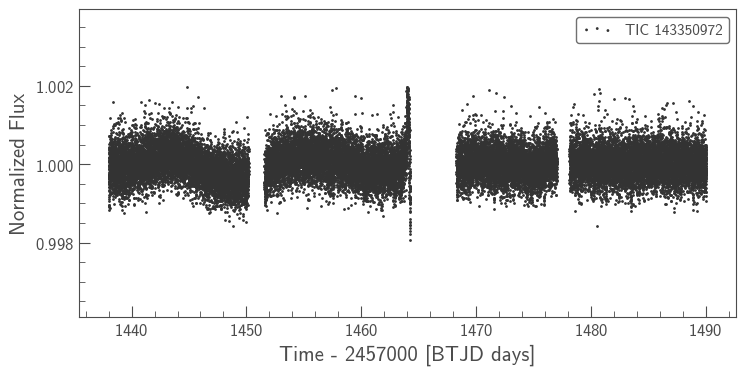

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -43004.94207487107 -> -42106.88530698944


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -20995.660449249142 -> -14323.868050290108


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -14323.868050290113 -> -14239.318397644573


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -14239.318397644573 -> -14239.31802100514


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -14239.31802100514 -> -14237.808869567125


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -14237.808869567125 -> -14237.786579412217


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -14237.786579412217 -> -14236.776507656032


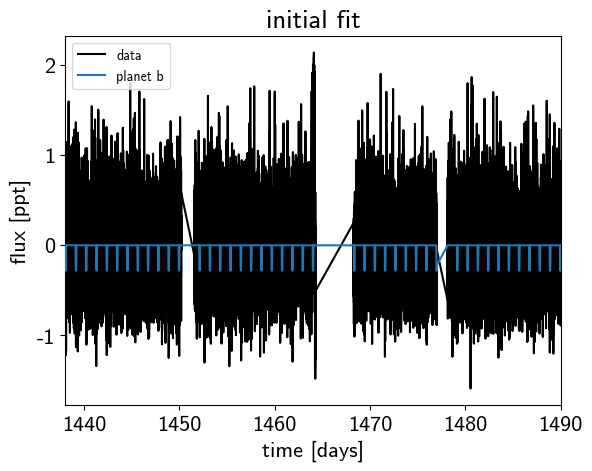

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 68.82draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:09,  9.66draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:17,  5.05draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:22,  3.88draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:33,  2.62draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:33,  2.53draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:32,  2.52draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:32,  2.53draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:26,  2.98draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:36,  2.19draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:35,  2.20draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:33,  2.24draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:31,  2.30draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:30,  2.33draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:25,  2.76draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:11<00:32,  2.12draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:26,  2.53draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:32,  2.08draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:12<00:28,  2.34draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:30,  2.12draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:13<00:26,  2.43draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:30,  2.05draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:13<00:24,  2.53draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:14<00:31,  1.95draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:15<00:29,  2.02draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:16<00:27,  2.06draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:17<00:25,  2.12draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:18<00:24,  2.16draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:19<00:22,  2.24draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:20<00:21,  2.28draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:20<00:19,  2.36draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:21<00:18,  2.42draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:21<00:14,  2.94draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:22<00:18,  2.37draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:22<00:14,  2.87draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:23<00:17,  2.38draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:23<00:13,  2.86draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:23<00:13,  2.93draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:23<00:11,  3.17draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:24<00:13,  2.66draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:24<00:12,  2.92draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:25<00:13,  2.59draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:25<00:12,  2.58draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:26<00:12,  2.54draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:27<00:11,  2.52draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:28<00:11,  2.43draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:29<00:11,  2.17draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:30<00:10,  2.15draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:30<00:07,  2.79draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:31<00:09,  2.13draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:31<00:08,  2.33draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:32<00:08,  2.21draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:32<00:08,  2.05draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:33<00:08,  2.10draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:33<00:08,  1.92draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:34<00:07,  2.00draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:34<00:07,  1.98draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:35<00:06,  2.06draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:35<00:05,  2.12draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:36<00:05,  2.13draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:36<00:04,  2.15draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:37<00:04,  1.88draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:37<00:03,  2.33draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:38<00:03,  1.77draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:39<00:02,  1.84draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:40<00:01,  1.92draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:43<00:00,  1.11draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:43<00:00,  2.37draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 13.07draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:15,  5.87draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:16,  5.41draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:26,  3.36draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:26,  3.33draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:30,  2.83draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:30,  2.79draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:32,  2.63draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:31,  2.65draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:33,  2.51draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:33,  2.43draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:32,  2.46draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:36,  2.19draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:30,  2.62draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:37,  2.10draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:34,  2.23draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:30,  2.49draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:31,  2.33draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:30,  2.36draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:30,  2.36draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:32,  2.18draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:28,  2.46draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:33,  2.08draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:26,  2.61draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:20,  3.29draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:27,  2.39draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:23,  2.80draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:31,  2.00draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:24,  2.56draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:13<00:32,  1.93draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:14<00:26,  2.35draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:14<00:31,  1.92draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:15<00:24,  2.40draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:15<00:30,  1.91draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:16<00:24,  2.36draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:16<00:29,  1.93draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:23,  2.35draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:17<00:29,  1.82draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:18<00:27,  1.87draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:18<00:21,  2.38draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:19<00:28,  1.75draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:20<00:26,  1.79draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:21<00:20,  2.25draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:22<00:25,  1.74draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:22<00:21,  1.97draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:23<00:19,  2.18draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:24<00:23,  1.72draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:24<00:21,  1.85draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:25<00:15,  2.44draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:25<00:18,  1.94draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:26<00:13,  2.55draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:26<00:17,  1.95draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:27<00:15,  2.02draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:27<00:12,  2.53draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:28<00:15,  1.88draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:29<00:14,  1.97draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:29<00:10,  2.46draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:30<00:14,  1.78draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:31<00:12,  1.86draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:32<00:11,  1.88draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:33<00:08,  2.30draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:33<00:08,  2.17draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:34<00:08,  2.22draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:34<00:07,  2.26draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:35<00:07,  2.11draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:35<00:06,  2.36draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:36<00:06,  2.11draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:36<00:05,  2.36draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:36<00:05,  2.05draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:37<00:04,  2.38draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:37<00:04,  2.04draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:38<00:03,  2.52draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:38<00:03,  2.05draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:38<00:02,  2.61draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:39<00:02,  2.06draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:40<00:02,  1.70draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:41<00:02,  1.53draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:42<00:01,  1.74draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:42<00:00,  1.56draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:45<00:00,  1.39s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<03:03,  1.11draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<02:16,  1.47draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<02:06,  1.58draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:47,  1.85draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:44,  1.88draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:33,  2.11draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:34,  2.06draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:26,  2.24draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:25,  2.25draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:26,  2.19draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:06<01:07,  2.80draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<01:08,  2.74draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:01,  3.01draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:15,  2.44draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:06,  2.75draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:08<01:19,  2.29draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:08<01:11,  2.53draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:17,  2.34draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:09<01:17,  2.33draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:10<01:17,  2.30draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:10<01:03,  2.77draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:10<00:58,  3.03draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:11<01:19,  2.19draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:11<01:04,  2.70draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:12<01:27,  1.99draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:12<01:09,  2.48draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:13<01:29,  1.92draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:13<01:10,  2.40draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:14<01:26,  1.96draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:14<01:09,  2.41draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:15<01:23,  2.01draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:15<01:06,  2.48draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:15<01:07,  2.45draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:16<01:08,  2.39draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:16<00:55,  2.93draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:16<00:44,  3.58draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:16<00:37,  4.27draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:17<00:45,  3.48draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:17<00:55,  2.81draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:18<00:55,  2.82draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:18<01:08,  2.25draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:19<00:57,  2.68draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:19<00:59,  2.57draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:20<01:02,  2.42draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:20<01:03,  2.37draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:21<01:02,  2.37draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:21<01:02,  2.35draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:21<00:53,  2.77draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:21<00:47,  3.06draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:22<00:58,  2.48draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:22<00:52,  2.76draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:23<01:07,  2.12draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:23<00:52,  2.73draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:24<00:53,  2.64draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:24<00:39,  3.50draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:24<00:57,  2.42draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:25<00:50,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:25<01:01,  2.23draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:26<00:53,  2.51draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:26<01:11,  1.88draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:27<00:53,  2.47draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:27<00:58,  2.24draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:27<00:57,  2.26draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:28<00:50,  2.53draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:28<00:50,  2.54draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:29<00:38,  3.26draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:29<00:56,  2.22draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:30<00:47,  2.64draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:30<01:06,  1.87draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:31<01:02,  1.95draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:32<00:48,  2.50draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:32<01:05,  1.82draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:33<00:53,  2.23draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:33<01:04,  1.84draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:34<01:00,  1.92draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:35<00:56,  2.02draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:36<00:53,  2.09draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:37<00:51,  2.14draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:38<00:49,  2.20draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:39<00:47,  2.25draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:39<00:34,  3.00draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:40<00:48,  2.14draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:40<00:35,  2.87draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:40<00:44,  2.26draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:41<00:34,  2.89draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:41<00:43,  2.26draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:41<00:33,  2.90draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:42<00:42,  2.25draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:42<00:33,  2.86draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:42<00:31,  2.96draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:43<00:33,  2.77draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:43<00:35,  2.56draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:43<00:27,  3.27draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:44<00:33,  2.72draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:44<00:31,  2.81draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:45<00:37,  2.37draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:45<00:34,  2.52draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:46<00:38,  2.24draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:46<00:34,  2.44draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:47<00:38,  2.19draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:47<00:36,  2.30draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:48<00:41,  2.00draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:48<00:34,  2.38draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:48<00:26,  3.01draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:49<00:33,  2.35draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:49<00:25,  3.03draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:49<00:21,  3.41draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:50<00:30,  2.38draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:51<00:30,  2.40draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:51<00:34,  2.05draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:51<00:29,  2.41draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:52<00:32,  2.11draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:53<00:30,  2.17draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:54<00:28,  2.27draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:54<00:26,  2.35draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:55<00:23,  2.60draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:55<00:22,  2.67draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:56<00:24,  2.41draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:56<00:21,  2.67draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:57<00:21,  2.60draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:58<00:20,  2.58draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:58<00:17,  2.91draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:59<00:18,  2.76draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:59<00:14,  3.36draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:00<00:17,  2.73draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:00<00:15,  2.91draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:01<00:17,  2.51draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:01<00:16,  2.70draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:01<00:13,  3.14draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:02<00:13,  3.20draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:02<00:15,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:02<00:11,  3.38draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:03<00:14,  2.55draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:03<00:12,  2.90draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:03<00:10,  3.29draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:04<00:11,  2.95draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:04<00:12,  2.67draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:05<00:12,  2.58draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:05<00:13,  2.43draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:05<00:11,  2.61draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:06<00:09,  3.03draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:06<00:10,  2.58draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:07<00:10,  2.61draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:07<00:10,  2.41draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:08<00:10,  2.35draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:09<00:09,  2.32draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:09<00:09,  2.29draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:10<00:08,  2.26draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:11<00:06,  2.76draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:11<00:06,  2.83draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:11<00:06,  2.60draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:12<00:06,  2.42draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:12<00:06,  2.22draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:13<00:05,  2.19draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:14<00:04,  2.18draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:14<00:03,  2.57draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:15<00:03,  2.08draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:16<00:03,  2.02draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:17<00:04,  1.42draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:18<00:03,  1.27draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:19<00:03,  1.21draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:19<00:02,  1.42draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:20<00:01,  1.55draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:21<00:00,  1.35draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:24<00:00,  1.56s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:13, 29.80draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:12, 32.38draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:13, 29.48draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:13, 29.30draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:17, 21.94draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:18, 20.47draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:16, 23.13draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:16, 23.32draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:01<00:17, 21.57draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:01<00:15, 23.70draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:01<00:16, 22.08draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:01<00:25, 14.49draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:24, 14.65draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:02<00:23, 15.39draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:02<00:20, 17.45draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:02<00:18, 19.08draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:02<00:16, 20.61draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:02<00:17, 19.69draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:02<00:21, 16.19draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:03<00:20, 16.64draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:03<00:20, 16.71draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:03<00:18, 18.52draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:03<00:17, 18.62draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:03<00:18, 18.21draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:03<00:18, 18.23draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:03<00:14, 22.52draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:03<00:13, 23.95draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:04<00:16, 19.50draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:04<00:14, 21.22draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:04<00:14, 21.62draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:04<00:12, 24.39draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:04<00:11, 27.14draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:04<00:10, 27.93draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:05<00:11, 26.44draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:05<00:12, 22.77draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:05<00:10, 27.33draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:05<00:11, 23.87draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:05<00:12, 21.92draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:05<00:12, 21.48draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:05<00:12, 21.31draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:06<00:27,  9.77draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:06<00:30,  8.91draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:07<00:38,  6.85draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:07<00:39,  6.69draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:07<00:34,  7.52draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:07<00:28,  9.24draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:08<00:35,  7.24draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:08<00:28,  9.08draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:08<00:24, 10.17draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:08<00:21, 11.73draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:08<00:18, 13.12draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:09<00:20, 11.77draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:09<00:19, 12.39draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:09<00:15, 15.24draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:09<00:15, 15.31draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:09<00:16, 14.51draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:09<00:15, 15.10draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:09<00:14, 15.60draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:10<00:15, 15.21draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:10<00:16, 13.75draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:10<00:13, 16.12draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:10<00:15, 14.86draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:10<00:14, 15.42draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:10<00:14, 15.04draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:10<00:13, 15.62draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:11<00:11, 18.66draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:11<00:10, 20.93draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:11<00:10, 19.74draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:11<00:09, 20.68draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:11<00:10, 19.83draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:11<00:09, 21.08draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:12<00:09, 20.08draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:12<00:08, 21.42draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:12<00:12, 14.87draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:12<00:13, 13.43draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:12<00:12, 14.57draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:12<00:11, 15.61draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:12<00:09, 17.97draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:13<00:09, 18.74draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:13<00:12, 13.49draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:13<00:14, 11.95draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:13<00:13, 12.65draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:14<00:12, 13.74draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:14<00:11, 14.63draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:14<00:09, 16.73draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:14<00:07, 20.07draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:14<00:07, 19.20draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:14<00:10, 14.40draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:14<00:08, 17.67draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:15<00:10, 13.56draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:15<00:10, 12.75draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:15<00:10, 12.69draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:16<00:14,  9.37draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:16<00:12, 10.58draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:16<00:11, 11.71draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:16<00:10, 12.64draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:16<00:10, 12.57draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:16<00:08, 14.61draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:16<00:08, 14.35draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:17<00:09, 12.19draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:17<00:08, 13.69draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:17<00:07, 14.85draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:17<00:06, 17.16draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:17<00:05, 18.19draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:18<00:08, 12.14draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:18<00:10,  9.56draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:18<00:09, 10.32draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:18<00:09, 10.60draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:18<00:07, 12.91draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:18<00:06, 14.85draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:19<00:06, 15.12draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:19<00:05, 17.66draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:19<00:05, 14.85draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:19<00:05, 15.60draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:19<00:04, 17.91draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:19<00:05, 15.33draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:20<00:04, 15.86draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:20<00:04, 16.59draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:20<00:04, 17.48draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:20<00:04, 15.45draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:20<00:03, 17.00draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:20<00:04, 14.36draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:20<00:03, 17.12draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:21<00:03, 18.03draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:21<00:03, 16.64draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:21<00:02, 17.31draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:21<00:02, 16.75draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:21<00:02, 17.51draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:21<00:02, 18.30draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:22<00:02, 17.41draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:22<00:02, 17.63draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:22<00:02, 12.69draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:22<00:03, 10.91draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:22<00:03,  8.38draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:23<00:03,  9.32draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:23<00:02, 10.68draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:23<00:02, 12.03draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:23<00:01, 13.56draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:23<00:01, 14.57draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:23<00:01, 15.55draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:23<00:01, 15.43draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:24<00:01, 10.72draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:24<00:01,  9.17draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:24<00:01,  8.30draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:24<00:01,  9.68draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:25<00:00,  9.08draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:25<00:00,  8.48draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:25<00:00,  6.67draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:25<00:00,  7.08draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:25<00:00,  7.48draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:26<00:00,  6.85draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:26<00:00,  8.45draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:26<00:00, 15.41draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/804 [00:00<00:44, 18.12draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:38, 20.68draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:37, 20.93draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:38, 20.74draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:35, 22.21draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:00<00:34, 22.93draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:31, 24.65draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:01<00:38, 20.16draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:01<00:36, 21.45draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:01<00:32, 23.68draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:31, 24.17draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:33, 23.05draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:29, 25.53draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:26, 28.27draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:02<00:31, 23.66draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:02<00:31, 24.09draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:29, 25.36draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:32, 22.87draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:02<00:38, 19.35draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:02<00:37, 19.96draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:02<00:35, 20.64draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:03<00:34, 21.48draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:03<00:31, 23.14draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:03<00:34, 21.02draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:03<00:33, 21.48draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:03<00:27, 25.78draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:04<01:09, 10.28draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:05<02:07,  5.58draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:06<02:12,  5.38draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:06<03:09,  3.74draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:07<04:55,  2.39draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:08<04:34,  2.57draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:08<05:36,  2.09draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:08<04:40,  2.51draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:09<04:49,  2.43draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:09<04:11,  2.79draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:09<03:47,  3.08draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:10<03:03,  3.80draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:10<02:33,  4.55draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:10<02:12,  5.25draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:10<02:07,  5.46draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:10<01:40,  6.91draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:10<01:20,  8.53draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:11<01:12,  9.45draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:11<01:32,  7.43draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:11<01:19,  8.58draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:11<01:10,  9.65draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:12<01:29,  7.55draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:12<01:14,  9.03draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:12<01:12,  9.26draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:12<00:58, 11.42draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:12<00:50, 13.23draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:13<00:43, 15.22draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:13<00:41, 16.13draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:13<00:39, 16.71draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:13<00:49, 13.42draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:13<00:40, 16.14draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:13<00:40, 16.02draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:14<00:41, 15.53draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:14<00:38, 16.67draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:14<00:36, 17.76draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:14<00:32, 19.87draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:14<00:26, 23.68draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:14<00:28, 21.93draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:14<00:27, 22.97draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:14<00:26, 23.80draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:15<00:27, 22.74draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:15<00:26, 23.02draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:15<00:27, 22.42draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:15<00:26, 23.55draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:15<00:23, 26.43draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:15<00:20, 29.94draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:15<00:17, 33.71draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:15<00:16, 36.53draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:16<00:14, 41.27draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:16<00:14, 40.01draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:16<00:12, 45.56draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:16<00:12, 44.89draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:16<00:13, 41.94draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:16<00:12, 43.18draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:16<00:12, 43.49draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:16<00:11, 46.53draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:17<00:12, 42.68draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:17<00:14, 37.53draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:17<00:14, 36.63draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:17<00:14, 37.12draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:17<00:14, 35.43draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:17<00:16, 31.44draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:17<00:16, 32.04draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:17<00:15, 32.74draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:18<00:15, 33.17draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:18<00:17, 28.13draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:18<00:17, 28.65draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:18<00:19, 25.79draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:18<00:21, 23.31draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:18<00:19, 24.82draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:18<00:18, 25.92draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:19<00:20, 23.15draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:19<00:20, 24.01draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:19<00:19, 24.04draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:19<00:17, 27.09draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:19<00:18, 25.57draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:19<00:26, 18.00draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:20<00:31, 14.93draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:20<00:29, 15.93draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:20<00:28, 16.16draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:20<00:26, 17.09draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:20<00:24, 18.51draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:20<00:24, 18.65draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:20<00:21, 20.54draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:20<00:22, 20.36draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:21<00:22, 19.65draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:21<00:20, 21.89draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:21<00:20, 21.44draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:21<00:21, 20.47draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:21<00:21, 19.71draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:21<00:18, 23.03draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:21<00:18, 23.08draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:22<00:18, 22.97draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:22<00:19, 21.10draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:22<00:22, 18.59draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:22<00:20, 20.54draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:22<00:21, 19.50draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:22<00:18, 22.43draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:23<00:16, 23.94draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:23<00:15, 25.30draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:23<00:14, 28.24draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:23<00:12, 30.72draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:23<00:12, 32.04draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:23<00:11, 34.36draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:23<00:10, 34.55draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:23<00:10, 34.86draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:23<00:12, 30.48draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:24<00:13, 26.57draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:24<00:14, 25.77draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:24<00:13, 26.78draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:24<00:13, 25.70draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:24<00:13, 25.66draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:24<00:12, 28.02draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:24<00:11, 30.32draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:25<00:10, 31.69draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:25<00:10, 33.17draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:25<00:08, 37.56draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:25<00:08, 38.91draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:25<00:07, 40.40draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:25<00:08, 39.29draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:25<00:07, 42.95draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:25<00:06, 43.74draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:25<00:06, 46.24draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:26<00:06, 44.66draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:26<00:06, 41.62draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:26<00:06, 42.60draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:26<00:07, 37.41draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:26<00:07, 36.94draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:26<00:07, 35.20draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:26<00:08, 31.49draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:27<00:07, 32.89draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:27<00:07, 33.41draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:27<00:07, 34.99draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:27<00:08, 29.12draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:27<00:08, 30.29draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:27<00:09, 26.61draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:27<00:08, 27.64draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:28<00:09, 23.92draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:28<00:10, 21.83draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:28<00:09, 24.93draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:28<00:08, 25.38draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:28<00:07, 28.26draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:28<00:07, 27.69draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:28<00:07, 29.46draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:28<00:06, 31.04draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:29<00:06, 31.63draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:29<00:06, 32.07draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:29<00:06, 29.88draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:29<00:05, 31.95draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:29<00:05, 33.46draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:29<00:05, 31.00draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:29<00:05, 33.98draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:29<00:05, 30.26draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:30<00:05, 32.20draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:30<00:05, 32.77draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:30<00:05, 29.94draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:30<00:04, 33.82draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:30<00:04, 37.24draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:30<00:03, 39.77draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:30<00:03, 39.18draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:30<00:03, 40.84draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:31<00:03, 35.45draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:31<00:03, 36.21draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:31<00:03, 35.55draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:31<00:03, 33.21draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:31<00:03, 30.55draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:31<00:03, 29.32draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:31<00:03, 31.54draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:32<00:03, 32.75draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:32<00:02, 36.09draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:32<00:02, 34.15draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:32<00:02, 30.16draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:32<00:02, 31.21draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:32<00:02, 30.19draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:33<00:03, 23.43draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:33<00:03, 22.38draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [00:33<00:03, 20.75draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:33<00:03, 18.00draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:33<00:03, 17.91draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:33<00:03, 17.54draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:33<00:03, 18.79draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:34<00:02, 19.88draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:34<00:02, 21.64draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:34<00:02, 21.36draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:34<00:02, 21.94draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:34<00:02, 20.53draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:35<00:06,  5.90draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:40<00:33,  1.16draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:44<00:40,  1.09s/draws]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:45<00:39,  1.11s/draws]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:46<00:44,  1.27s/draws]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:47<00:38,  1.13s/draws]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:48<00:34,  1.04s/draws]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:49<00:31,  1.03draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:50<00:28,  1.08draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:51<00:26,  1.12draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:51<00:21,  1.34draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:52<00:21,  1.28draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:52<00:17,  1.50draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:53<00:15,  1.67draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:53<00:13,  1.86draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:53<00:11,  2.02draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:54<00:10,  2.16draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:54<00:08,  2.61draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:54<00:06,  3.06draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:54<00:05,  3.48draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:55<00:04,  3.84draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:55<00:04,  4.16draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:55<00:03,  4.41draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:55<00:03,  4.59draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:55<00:03,  4.74draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:56<00:02,  4.85draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:56<00:02,  5.73draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:56<00:01,  7.30draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:56<00:00,  8.46draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:56<00:00,  9.49draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:56<00:00, 11.21draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:56<00:00, 12.48draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:56<00:00, 14.12draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/4404 [00:00<04:22, 16.80draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<03:41, 19.87draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<03:29, 20.94draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<03:17, 22.22draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<03:03, 23.88draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<03:06, 23.51draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<03:04, 23.74draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<02:49, 25.83draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<02:50, 25.73draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<02:59, 24.42draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<02:38, 27.61draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:01<02:43, 26.76draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:01<02:28, 29.44draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:01<02:32, 28.55draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:01<02:18, 31.52draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<03:13, 22.43draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<03:01, 23.93draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:02<02:50, 25.41draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:02<03:34, 20.26draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<04:36, 15.67draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:03<05:08, 14.06draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:03<04:23, 16.45draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<03:50, 18.76draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:03<03:26, 21.00draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:03<03:35, 20.03draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:03<03:44, 19.21draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<04:15, 16.89draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:03<04:12, 17.10draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:04<03:37, 19.85draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:04<03:12, 22.34draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:04<02:52, 25.00draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:04<02:34, 27.84draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:04<02:39, 26.85draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:04<02:54, 24.66draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<03:13, 22.14draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:05<03:33, 20.08draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:05<03:15, 21.93draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:05<03:08, 22.69draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:05<02:49, 25.16draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:05<03:02, 23.38draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:05<02:42, 26.25draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:05<02:26, 29.07draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:06<02:11, 32.42draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:06<02:09, 32.94draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:06<03:06, 22.80draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:06<03:08, 22.47draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:06<03:06, 22.75draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:06<02:55, 24.19draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:07<02:51, 24.63draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:07<02:26, 28.88draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:07<02:13, 31.70draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:07<02:04, 34.01draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:07<02:23, 29.39draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:07<02:22, 29.52draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:07<02:30, 28.00draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:08<02:39, 26.41draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:08<02:34, 27.20draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:08<02:33, 27.26draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:08<02:35, 27.04draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:08<02:36, 26.73draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:08<02:24, 28.92draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:08<02:29, 28.04draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:08<02:23, 29.11draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:08<02:12, 31.62draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:09<02:11, 31.67draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:09<02:06, 33.04draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:09<02:01, 34.30draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:09<02:04, 33.53draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:09<02:20, 29.68draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:09<02:12, 31.34draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:09<02:25, 28.57draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:09<02:24, 28.63draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:10<02:07, 32.47draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:10<02:00, 34.39draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:10<02:01, 34.05draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:10<02:26, 28.16draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:10<02:33, 26.92draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:10<02:19, 29.56draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:10<02:28, 27.69draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:11<02:09, 31.63draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:11<01:56, 35.14draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:11<01:43, 39.65draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:11<01:33, 43.69draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:11<01:31, 44.71draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:11<01:25, 47.76draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:11<01:44, 39.11draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:12<02:01, 33.39draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:12<02:20, 28.92draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:12<02:28, 27.40draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:12<02:42, 24.89draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:12<02:24, 27.96draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:12<02:26, 27.55draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:12<02:15, 29.92draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:13<02:18, 29.26draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:13<02:04, 32.43draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:13<02:15, 29.81draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:13<02:20, 28.61draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:13<02:29, 26.88draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:13<02:27, 27.33draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:13<02:14, 29.81draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:13<02:06, 31.81draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:14<01:52, 35.77draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:14<02:20, 28.47draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:14<02:17, 29.04draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:14<02:19, 28.73draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:14<02:08, 31.04draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:14<02:13, 29.86draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:14<01:57, 33.76draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:15<02:06, 31.55draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:15<02:01, 32.74draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:15<01:55, 34.28draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:15<01:44, 37.88draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:15<01:44, 37.97draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:15<01:45, 37.32draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:15<01:43, 38.33draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:15<01:50, 35.75draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:16<01:48, 36.42draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:16<01:56, 33.83draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:16<02:03, 31.96draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:16<02:10, 30.02draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:16<02:22, 27.52draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:16<02:10, 30.11draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:16<02:04, 31.41draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:16<01:51, 35.10draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:17<01:46, 36.75draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:17<01:36, 40.41draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:17<01:31, 42.50draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:17<02:14, 28.94draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:17<02:11, 29.54draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:17<02:01, 31.93draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:17<01:58, 32.74draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:18<01:53, 34.12draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:18<02:03, 31.26draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:18<01:56, 33.18draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:18<02:10, 29.61draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:18<02:17, 28.10draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:18<02:46, 23.18draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:18<02:53, 22.22draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:19<02:47, 22.93draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:19<02:29, 25.75draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:19<02:21, 27.14draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:19<02:33, 24.95draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:19<03:24, 18.78draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:19<03:04, 20.80draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:19<02:46, 22.94draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:20<02:58, 21.46draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:20<03:03, 20.84draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:20<02:49, 22.55draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:20<02:46, 22.97draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:20<03:03, 20.73draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:20<02:58, 21.35draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:21<03:18, 19.15draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:21<03:37, 17.47draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:21<03:51, 16.45draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:21<04:04, 15.54draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:21<04:15, 14.89draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:21<03:53, 16.24draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:22<03:48, 16.59draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:22<03:37, 17.46draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:22<03:56, 16.02draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:22<03:51, 16.36draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:22<04:04, 15.49draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:22<03:40, 17.15draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:22<03:24, 18.43draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:22<03:05, 20.32draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:23<03:06, 20.25draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:23<03:09, 19.89draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:23<02:53, 21.67draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:23<03:36, 17.37draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:23<03:46, 16.57draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:23<03:42, 16.86draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:24<03:39, 17.07draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:24<04:35, 13.63draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:24<04:23, 14.26draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:24<04:02, 15.48draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:24<03:46, 16.56draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:24<03:45, 16.61draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:24<03:21, 18.52draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:25<03:15, 19.08draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:25<03:29, 17.83draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:25<04:31, 13.77draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:25<05:07, 12.13draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:25<07:13,  8.60draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:26<06:49,  9.10draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:26<05:57, 10.41draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:26<06:00, 10.33draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:26<05:06, 12.15draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:26<04:55, 12.59draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:26<04:12, 14.74draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:27<03:40, 16.81draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:27<03:24, 18.14draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:27<03:04, 20.07draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:27<02:58, 20.76draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:27<02:52, 21.49draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:27<03:12, 19.20draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:28<03:33, 17.30draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:28<03:54, 15.76draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:28<03:37, 16.95draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:28<03:12, 19.16draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:28<02:54, 21.08draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:28<02:44, 22.42draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:28<02:35, 23.66draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:29<02:27, 24.93draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:29<02:19, 26.22draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:29<02:14, 27.25draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:29<02:13, 27.47draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:29<02:12, 27.68draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:29<02:41, 22.63draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:29<02:51, 21.28draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:29<02:53, 21.05draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:30<02:41, 22.55draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:30<02:24, 25.17draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:30<02:26, 24.75draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:30<02:14, 27.11draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:30<02:22, 25.49draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:30<02:07, 28.49draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:30<01:55, 31.35draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:31<02:10, 27.72draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:31<02:24, 24.99draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:31<02:17, 26.28draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:31<02:38, 22.75draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:31<02:25, 24.70draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [00:31<02:04, 28.91draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:31<02:00, 29.88draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:32<01:52, 31.85draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:32<01:50, 32.55draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:32<02:10, 27.50draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:32<02:23, 24.83draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [00:32<02:40, 22.27draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:32<02:37, 22.65draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [00:32<02:26, 24.38draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:33<02:23, 24.88draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:33<02:09, 27.39draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:33<02:11, 27.07draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:33<02:08, 27.54draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:33<02:04, 28.43draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:33<02:10, 27.10draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:33<02:18, 25.49draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:34<02:18, 25.53draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:34<02:03, 28.58draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:34<02:07, 27.74draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:34<02:03, 28.62draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:34<01:55, 30.54draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:34<01:47, 32.84draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:34<01:41, 34.58draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:35<02:05, 28.02draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:35<02:22, 24.50draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:35<02:32, 22.87draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [00:35<02:24, 24.20draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:35<02:19, 24.98draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:35<02:05, 27.75draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:35<02:14, 25.97draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:36<02:05, 27.62draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:36<01:56, 29.75draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:36<01:58, 29.18draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [00:36<02:03, 27.98draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:36<01:59, 28.92draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:36<01:53, 30.51draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:36<01:46, 32.45draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:36<01:44, 33.03draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [00:37<01:42, 33.55draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:37<01:32, 37.03draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:37<01:26, 39.86draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:37<01:53, 30.21draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:37<02:09, 26.48draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:38<03:11, 17.90draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:38<03:11, 17.85draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:38<03:29, 16.28draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:38<03:28, 16.38draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:38<03:26, 16.50draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:38<04:00, 14.20draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:39<03:39, 15.55draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:39<03:25, 16.58draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:39<03:54, 14.49draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:39<04:18, 13.17draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:39<03:48, 14.85draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:39<03:14, 17.41draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:39<02:54, 19.42draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:40<02:37, 21.48draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:40<02:29, 22.58draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:40<02:19, 24.29draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [00:40<02:00, 28.12draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:40<01:44, 32.15draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:40<01:56, 28.98draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:40<01:49, 30.84draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [00:40<01:50, 30.49draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:40<01:45, 31.70draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:41<01:41, 33.07draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [00:41<01:39, 33.51draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:41<01:33, 35.78draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:41<01:25, 39.01draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:41<01:25, 38.83draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:41<01:27, 38.23draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:41<01:28, 37.53draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:41<01:29, 37.01draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:41<01:29, 37.24draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:42<01:39, 33.36draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [00:42<01:42, 32.44draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:42<01:29, 36.79draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:42<01:36, 34.12draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:42<01:32, 35.48draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:42<01:33, 35.16draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:42<01:46, 30.90draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:43<01:39, 32.95draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:43<01:52, 29.02draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:43<01:54, 28.54draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:43<01:47, 30.55draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:43<01:45, 30.99draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [00:43<01:42, 31.82draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:43<01:39, 32.75draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:44<01:32, 35.27draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:44<01:25, 38.12draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [00:44<01:29, 36.25draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:44<01:19, 40.93draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:44<01:28, 36.35draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:44<01:31, 35.13draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [00:44<01:27, 36.91draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:44<01:28, 36.37draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:45<01:30, 35.61draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:45<01:22, 38.90draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:45<01:31, 35.05draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:45<01:40, 31.98draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [00:45<01:46, 30.11draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:45<01:48, 29.50draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:45<01:54, 27.78draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [00:46<01:51, 28.45draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:46<02:04, 25.56draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:46<02:01, 26.17draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:46<01:49, 28.99draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:46<01:51, 28.29draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [00:46<02:04, 25.37draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:46<01:59, 26.45draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:47<01:51, 28.43draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [00:47<02:00, 26.25draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:47<01:47, 29.26draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [00:47<01:38, 31.92draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [00:47<01:54, 27.32draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [00:47<01:53, 27.53draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [00:47<01:52, 27.89draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [00:48<02:26, 21.38draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:48<02:22, 21.95draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:48<02:24, 21.61draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:48<02:14, 23.17draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:48<02:19, 22.31draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:48<02:13, 23.36draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:48<02:18, 22.39draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:48<02:11, 23.69draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:49<02:00, 25.70draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [00:49<02:00, 25.65draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:49<01:57, 26.24draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [00:49<01:53, 27.35draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:49<01:46, 29.08draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [00:49<01:45, 29.34draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [00:49<01:51, 27.63draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:49<01:50, 27.88draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [00:50<02:04, 24.78draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:50<02:27, 20.87draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:50<02:09, 23.68draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:50<02:02, 24.95draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:50<01:49, 27.96draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:50<01:43, 29.58draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:50<01:44, 29.10draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:51<01:38, 30.93draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:51<01:28, 34.19draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:51<01:29, 34.10draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:51<01:21, 37.41draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:51<01:14, 40.35draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [00:51<01:15, 39.88draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:51<01:17, 38.80draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [00:51<01:14, 40.26draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [00:52<01:24, 35.53draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [00:52<01:19, 37.85draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [00:52<01:20, 37.24draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:52<01:22, 36.36draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:52<01:15, 39.51draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:52<01:19, 37.55draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [00:52<01:13, 40.35draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:52<01:11, 41.53draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:53<01:06, 44.57draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:53<01:03, 46.29draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [00:53<01:07, 43.43draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [00:53<01:05, 44.99draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:53<01:04, 45.53draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [00:53<01:05, 45.05draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [00:53<01:02, 46.83draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:53<01:05, 44.60draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:54<01:16, 38.32draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:54<01:12, 40.45draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:54<01:10, 41.38draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [00:54<01:06, 43.52draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [00:54<01:11, 40.53draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [00:54<01:08, 42.18draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [00:54<01:07, 42.62draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [00:54<01:09, 41.21draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [00:55<01:17, 37.22draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [00:55<01:19, 35.94draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [00:55<01:16, 37.42draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [00:55<01:15, 38.17draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [00:55<01:07, 42.08draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:55<01:11, 39.68draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:55<01:05, 43.32draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:55<01:05, 43.30draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:56<01:11, 39.56draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [00:56<01:15, 37.38draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [00:56<01:27, 32.37draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [00:56<01:36, 29.15draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [00:56<01:32, 30.44draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [00:56<01:26, 32.65draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [00:56<01:25, 32.84draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [00:57<01:24, 33.12draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [00:57<01:14, 37.59draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [00:57<01:14, 37.75draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [00:57<01:16, 36.41draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [00:57<01:30, 30.97draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [00:57<01:33, 29.88draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [00:57<01:31, 30.52draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [00:58<01:33, 29.75draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [00:58<01:43, 26.81draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [00:58<01:58, 23.33draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [00:58<01:55, 23.87draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:58<01:49, 25.29draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:58<01:33, 29.33draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [00:59<01:42, 26.97draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [00:59<01:31, 30.04draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:59<01:20, 34.01draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [00:59<01:17, 35.24draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:59<01:26, 31.68draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [00:59<01:27, 31.26draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [00:59<01:23, 32.69draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [00:59<01:28, 30.85draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [01:00<01:26, 31.27draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:00<01:28, 30.73draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [01:00<01:19, 33.86draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:00<01:26, 31.34draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [01:00<01:30, 29.85draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [01:00<01:23, 32.27draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:00<01:28, 30.47draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:00<01:21, 32.80draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [01:01<01:28, 30.43draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:01<01:16, 34.97draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [01:01<01:20, 33.24draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:01<01:18, 34.11draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [01:01<01:16, 35.02draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [01:01<01:21, 32.66draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:01<01:33, 28.31draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [01:02<01:26, 30.55draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:02<01:34, 27.88draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [01:02<02:26, 18.04draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [01:02<02:31, 17.43draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [01:02<02:38, 16.61draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [01:03<03:05, 14.23draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:03<02:37, 16.71draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:03<02:38, 16.61draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [01:03<02:13, 19.62draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:03<02:03, 21.20draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:03<01:47, 24.32draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:03<01:53, 23.04draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:04<02:05, 20.82draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:04<01:57, 22.28draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:04<01:50, 23.54draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:04<01:36, 26.82draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [01:04<01:36, 27.00draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:04<01:34, 27.60draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [01:04<01:42, 25.35draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [01:05<02:32, 17.02draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [01:05<03:01, 14.22draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [01:05<02:57, 14.52draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [01:05<03:20, 12.90draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [01:05<02:47, 15.40draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:06<02:44, 15.68draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [01:06<02:44, 15.60draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:06<02:22, 18.02draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:06<02:09, 19.77draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:06<02:28, 17.22draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:06<02:23, 17.83draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:07<02:31, 16.86draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:07<02:27, 17.37draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:07<02:55, 14.55draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:07<03:17, 12.91draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:07<02:54, 14.61draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [01:07<02:57, 14.31draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [01:07<02:51, 14.87draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:08<03:07, 13.56draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:08<02:41, 15.68draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [01:08<02:37, 16.12draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:08<02:36, 16.24draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:08<02:30, 16.79draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:08<02:36, 16.20draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:08<02:26, 17.29draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:09<02:12, 19.04draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:09<01:52, 22.44draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:09<01:41, 24.76draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:09<01:37, 25.83draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [01:09<01:36, 25.99draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:09<01:44, 24.06draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:09<01:38, 25.32draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:09<01:35, 26.26draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [01:10<01:33, 26.56draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:10<01:42, 24.39draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:10<01:34, 26.39draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [01:10<01:27, 28.45draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:10<01:35, 26.04draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [01:10<01:30, 27.32draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:10<01:23, 29.63draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:10<01:36, 25.51draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:11<01:34, 26.03draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [01:11<01:45, 23.34draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [01:11<01:38, 24.93draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:11<01:34, 26.12draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:11<01:43, 23.82draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:11<01:49, 22.45draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [01:11<01:45, 23.28draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:11<01:41, 24.00draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:12<01:55, 21.14draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:12<01:45, 23.20draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:12<01:47, 22.59draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:12<01:40, 24.24draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:12<01:45, 22.99draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:12<01:32, 26.08draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:12<01:39, 24.26draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [01:13<01:32, 26.12draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [01:13<01:27, 27.73draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [01:13<01:22, 29.14draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:13<01:24, 28.45draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:13<01:23, 28.74draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:13<01:24, 28.53draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [01:13<01:24, 28.22draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:13<01:22, 29.01draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:14<01:36, 24.75draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:14<01:37, 24.37draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:14<01:40, 23.66draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:14<01:42, 23.16draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [01:14<01:41, 23.30draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:14<01:41, 23.28draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [01:15<02:13, 17.73draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:15<02:15, 17.45draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [01:15<02:49, 13.99draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [01:15<02:35, 15.22draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:15<02:29, 15.84draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [01:15<02:24, 16.33draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:15<02:18, 16.96draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:16<02:16, 17.22draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:16<02:14, 17.46draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:16<02:01, 19.39draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:16<01:55, 20.34draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:16<01:52, 20.88draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:16<01:48, 21.52draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:16<01:42, 22.86draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:16<01:30, 25.82draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:17<01:27, 26.54draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:17<01:24, 27.41draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:17<01:31, 25.33draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:17<01:33, 24.70draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [01:17<01:23, 27.81draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [01:17<01:32, 25.06draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:17<01:49, 21.01draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [01:18<01:34, 24.46draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:18<01:32, 25.00draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [01:18<01:25, 26.91draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:18<01:15, 30.17draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:18<01:14, 30.58draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:18<01:11, 31.99draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [01:18<01:09, 32.77draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:18<01:06, 34.13draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:18<01:05, 34.73draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:19<01:03, 35.43draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [01:19<00:56, 39.73draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:19<00:58, 38.36draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:19<00:55, 40.51draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [01:19<00:56, 39.74draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:19<00:59, 37.98draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [01:19<00:55, 40.59draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [01:19<00:56, 39.54draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [01:20<00:58, 37.86draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [01:20<00:59, 37.40draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [01:20<00:57, 38.31draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [01:20<00:55, 40.15draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:20<00:53, 41.30draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [01:20<00:50, 43.48draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:20<00:49, 44.70draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:20<00:55, 39.79draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [01:21<00:58, 37.61draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [01:21<00:56, 38.50draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:21<00:54, 39.98draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:21<00:55, 39.22draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:21<00:55, 39.15draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:21<00:54, 39.37draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:21<00:53, 40.09draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:21<00:52, 41.42draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:22<01:10, 30.69draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:22<01:12, 29.42draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [01:22<01:14, 28.61draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [01:22<01:09, 30.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [01:22<01:04, 33.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [01:22<01:08, 31.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:22<01:06, 31.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:23<01:00, 34.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:23<00:59, 35.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [01:23<01:08, 30.92draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:23<01:01, 34.02draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [01:23<01:09, 30.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:23<01:08, 30.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:23<01:11, 29.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [01:24<01:13, 28.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:24<01:11, 29.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:24<01:13, 28.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [01:24<01:12, 28.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:24<01:18, 26.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:24<01:17, 26.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [01:24<01:12, 28.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [01:24<01:09, 29.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:25<01:11, 28.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:25<01:11, 28.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [01:25<01:06, 30.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:25<01:07, 30.27draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:25<01:04, 31.82draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:25<01:05, 31.05draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [01:25<01:05, 31.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [01:25<01:05, 31.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:26<01:01, 33.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:26<01:00, 33.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [01:26<00:58, 34.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:26<00:54, 37.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:26<00:51, 39.27draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:26<00:53, 37.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:26<00:52, 38.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [01:26<00:48, 41.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:26<00:48, 40.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:27<00:48, 40.60draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [01:27<00:48, 40.76draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [01:27<00:55, 35.46draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [01:27<00:58, 33.77draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [01:27<01:01, 31.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [01:27<01:02, 31.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [01:27<01:05, 29.94draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:28<01:05, 29.74draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [01:28<01:12, 27.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [01:28<01:17, 25.19draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [01:28<01:17, 25.03draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:28<01:09, 27.75draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [01:28<01:16, 25.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [01:28<01:13, 26.23draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:29<01:11, 27.09draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:29<01:04, 29.99draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [01:29<00:59, 32.30draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:29<00:56, 33.90draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:29<00:56, 34.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [01:29<00:58, 32.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [01:29<00:55, 34.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:29<00:54, 34.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [01:29<00:53, 35.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [01:29<00:51, 36.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:30<00:48, 38.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [01:30<00:48, 38.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:30<00:50, 37.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:30<00:47, 39.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [01:30<00:45, 41.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:30<00:44, 42.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [01:30<00:47, 39.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:30<00:46, 40.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:31<00:46, 39.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:31<00:46, 39.62draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [01:31<00:42, 43.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [01:31<00:46, 39.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [01:31<00:49, 37.34draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [01:31<00:49, 37.13draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [01:31<00:48, 37.85draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [01:31<00:47, 37.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:32<00:50, 36.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [01:32<00:49, 36.54draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [01:32<00:49, 36.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [01:32<00:48, 37.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:32<00:50, 35.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [01:32<00:45, 39.17draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [01:32<00:46, 38.23draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:32<00:43, 40.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:32<00:41, 42.84draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:33<00:46, 38.25draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [01:33<00:49, 36.09draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:33<00:42, 41.52draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:33<00:45, 38.77draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [01:33<00:49, 35.58draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [01:33<00:52, 33.16draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:33<01:00, 29.02draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:34<00:57, 30.22draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [01:34<00:56, 30.78draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [01:34<00:53, 32.19draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [01:34<00:54, 31.54draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [01:34<00:57, 30.15draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [01:34<00:50, 33.80draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:34<00:48, 35.60draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [01:35<00:47, 35.82draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [01:35<00:48, 34.93draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [01:35<00:46, 36.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [01:35<00:47, 35.50draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [01:35<00:49, 34.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:35<00:52, 31.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:35<00:51, 32.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [01:35<00:49, 34.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:36<00:45, 36.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:36<00:47, 34.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:36<00:46, 36.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [01:36<00:45, 36.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [01:36<00:49, 33.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [01:36<00:47, 34.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [01:36<00:47, 34.52draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [01:36<00:46, 35.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:36<00:46, 35.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [01:37<00:49, 32.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [01:37<00:53, 30.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [01:37<00:58, 27.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [01:37<00:59, 27.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:37<00:57, 28.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:37<01:01, 26.24draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [01:37<01:11, 22.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:38<01:14, 21.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [01:38<01:10, 22.96draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:38<01:11, 22.41draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [01:38<01:02, 25.69draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:38<00:58, 27.11draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [01:38<00:53, 29.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:38<00:57, 27.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [01:39<00:54, 29.14draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:39<00:49, 31.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [01:39<00:47, 33.08draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [01:39<00:42, 36.64draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [01:39<00:46, 33.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [01:39<00:55, 28.33draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:39<01:00, 25.84draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [01:39<00:54, 28.69draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [01:40<00:53, 29.19draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [01:40<00:46, 33.14draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:40<00:49, 31.31draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [01:40<00:47, 32.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:40<00:47, 32.25draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [01:40<00:49, 30.65draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [01:40<00:47, 32.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [01:40<00:44, 34.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [01:41<00:41, 36.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [01:41<00:39, 38.74draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:41<00:40, 37.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [01:41<00:39, 37.66draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [01:41<00:36, 40.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [01:41<00:39, 37.55draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [01:41<00:40, 36.95draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [01:41<00:40, 36.92draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [01:42<00:41, 35.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [01:42<00:40, 36.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [01:42<00:36, 40.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [01:42<00:36, 40.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [01:42<00:33, 43.62draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [01:42<00:34, 41.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [01:43<00:54, 26.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:43<00:59, 24.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [01:43<01:02, 23.01draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [01:43<01:07, 21.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [01:43<01:05, 21.77draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [01:43<01:05, 21.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [01:44<01:07, 21.03draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [01:44<00:59, 23.86draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [01:44<01:00, 23.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [01:44<00:57, 24.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [01:44<00:54, 25.73draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [01:44<00:53, 26.38draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [01:44<00:48, 28.83draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [01:44<00:49, 28.41draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [01:45<00:46, 29.82draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [01:45<00:47, 29.44draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [01:45<00:45, 30.74draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [01:45<00:46, 30.05draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [01:45<00:44, 31.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [01:45<00:40, 34.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [01:45<00:38, 35.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:46<00:40, 33.93draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [01:46<00:42, 32.14draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [01:46<00:40, 33.29draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [01:46<00:38, 34.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [01:46<00:38, 35.19draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [01:46<00:35, 38.01draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [01:46<00:36, 37.11draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [01:46<00:35, 37.93draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [01:46<00:34, 38.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [01:47<00:36, 36.56draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [01:47<00:37, 35.49draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [01:47<00:39, 33.64draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [01:47<00:38, 34.47draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [01:47<00:35, 36.45draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [01:47<00:32, 39.66draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [01:47<00:29, 43.79draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [01:47<00:32, 39.96draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [01:48<00:31, 40.19draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [01:48<00:37, 34.20draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [01:48<00:44, 28.62draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [01:48<00:43, 29.50draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [01:48<00:48, 26.08draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [01:48<00:49, 25.36draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [01:49<00:53, 23.38draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:49<00:51, 24.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [01:49<00:54, 22.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [01:49<00:52, 23.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [01:49<00:50, 24.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [01:49<00:56, 22.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [01:49<01:02, 20.03draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [01:50<00:51, 23.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [01:50<00:45, 27.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [01:50<00:44, 27.95draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:50<00:41, 29.71draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [01:50<00:41, 29.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:50<00:47, 25.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [01:50<00:49, 24.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [01:50<00:46, 25.93draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [01:51<00:48, 24.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [01:51<00:57, 20.88draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [01:51<00:50, 23.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [01:51<00:52, 22.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [01:51<00:54, 22.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [01:51<00:50, 23.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [01:52<00:48, 24.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [01:52<00:51, 23.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [01:52<00:48, 24.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:52<00:46, 25.19draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [01:52<00:45, 25.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [01:52<00:40, 28.63draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [01:52<00:39, 29.35draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [01:52<00:40, 28.64draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [01:53<00:49, 23.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [01:53<00:46, 24.69draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [01:53<00:51, 22.38draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [01:53<00:52, 21.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [01:53<00:50, 22.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [01:53<00:49, 23.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [01:53<00:49, 22.87draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [01:54<00:43, 26.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [01:54<00:41, 27.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [01:54<00:45, 24.97draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [01:54<00:44, 25.22draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [01:54<00:50, 22.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [01:55<01:09, 16.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [01:55<01:07, 16.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [01:55<01:01, 18.03draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [01:55<01:15, 14.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [01:55<01:02, 17.74draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [01:55<00:56, 19.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [01:55<00:52, 20.78draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:56<00:54, 20.01draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [01:56<01:06, 16.46draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:56<01:18, 13.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [01:56<01:29, 12.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [01:56<01:23, 13.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:57<01:31, 11.84draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [01:57<01:24, 12.73draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [01:57<01:16, 14.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [01:57<01:24, 12.82draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [01:57<01:22, 13.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [01:57<01:12, 14.83draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [01:57<01:07, 15.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [01:58<01:02, 16.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [01:58<00:54, 19.44draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [01:58<00:49, 21.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [01:58<00:56, 18.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [01:58<00:51, 20.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:58<00:51, 20.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [01:59<00:48, 21.66draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [01:59<00:49, 21.12draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [01:59<00:47, 21.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [01:59<00:44, 23.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [01:59<00:47, 21.81draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [01:59<00:41, 24.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [01:59<00:41, 24.90draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [01:59<00:39, 25.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [02:00<00:42, 24.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [02:00<00:44, 23.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [02:00<00:41, 24.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:00<00:39, 25.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [02:00<00:43, 23.06draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [02:00<00:37, 26.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:00<00:40, 24.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:01<00:48, 20.34draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [02:01<00:57, 17.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [02:01<01:04, 15.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [02:01<01:06, 14.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:01<01:02, 15.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:02<01:03, 15.45draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:02<01:00, 16.21draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [02:02<00:58, 16.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [02:02<00:57, 16.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [02:02<00:51, 18.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [02:02<00:51, 18.84draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [02:02<00:46, 20.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [02:03<00:46, 20.61draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [02:03<00:46, 20.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [02:03<00:42, 22.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:03<00:43, 22.08draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [02:03<00:42, 22.45draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:03<00:36, 25.53draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [02:03<00:34, 26.84draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [02:04<00:34, 27.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [02:04<00:33, 27.72draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [02:04<00:33, 28.09draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:04<00:32, 28.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:04<00:32, 28.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:04<00:31, 28.87draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [02:04<00:33, 27.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:04<00:30, 29.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [02:04<00:27, 33.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [02:05<00:24, 37.39draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:05<00:27, 32.49draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [02:05<00:32, 27.51draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [02:05<00:32, 27.77draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:05<00:34, 25.96draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [02:05<00:30, 28.85draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [02:06<00:35, 24.79draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [02:06<00:41, 20.88draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [02:06<00:36, 23.92draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [02:06<00:35, 24.40draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [02:06<00:38, 22.51draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [02:06<00:36, 23.39draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [02:06<00:36, 23.44draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [02:06<00:34, 24.84draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [02:07<00:33, 25.78draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:07<00:34, 24.74draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [02:07<00:33, 25.65draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [02:07<00:29, 28.23draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [02:07<00:29, 28.45draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:07<00:26, 32.01draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [02:07<00:26, 31.15draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [02:07<00:23, 34.47draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [02:08<00:23, 34.79draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [02:08<00:22, 35.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [02:08<00:22, 36.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:08<00:25, 32.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:08<00:25, 31.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [02:08<00:27, 29.43draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:08<00:26, 30.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [02:09<00:30, 26.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [02:09<00:33, 23.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [02:09<00:35, 22.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [02:09<00:33, 23.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [02:09<00:40, 19.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [02:09<00:34, 22.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:09<00:30, 25.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [02:10<00:34, 22.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:10<00:36, 21.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:10<00:36, 20.79draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [02:10<00:34, 22.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [02:10<00:31, 23.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:10<00:30, 24.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [02:10<00:29, 25.32draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [02:11<00:29, 25.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:11<00:26, 28.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:11<00:25, 29.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [02:11<00:23, 31.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [02:11<00:21, 33.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [02:11<00:21, 34.35draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:11<00:20, 35.61draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [02:11<00:20, 34.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:11<00:20, 35.08draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:12<00:20, 33.98draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:12<00:19, 35.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:12<00:24, 29.10draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [02:12<00:21, 32.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [02:12<00:21, 32.95draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [02:12<00:21, 32.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [02:12<00:21, 32.13draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [02:12<00:19, 34.95draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [02:13<00:18, 35.96draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [02:13<00:19, 35.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [02:13<00:17, 37.53draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [02:13<00:17, 37.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [02:13<00:20, 31.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [02:13<00:19, 33.70draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:13<00:18, 34.70draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:13<00:17, 35.87draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [02:14<00:18, 35.16draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:14<00:18, 34.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:14<00:17, 35.22draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [02:14<00:17, 35.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [02:14<00:17, 36.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [02:14<00:17, 35.12draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [02:14<00:18, 34.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [02:14<00:17, 35.03draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [02:14<00:16, 35.85draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [02:15<00:17, 35.35draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [02:15<00:17, 34.36draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [02:15<00:17, 33.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:15<00:15, 37.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [02:15<00:14, 39.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [02:15<00:15, 37.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [02:15<00:15, 36.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:15<00:15, 36.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:16<00:15, 36.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [02:16<00:15, 36.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [02:16<00:14, 38.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:16<00:15, 36.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [02:16<00:15, 36.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:16<00:15, 35.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:16<00:15, 34.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:16<00:16, 32.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:17<00:16, 32.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [02:17<00:15, 33.78draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [02:17<00:15, 34.98draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [02:17<00:13, 37.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:17<00:13, 37.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:17<00:14, 36.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [02:17<00:13, 37.26draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [02:17<00:13, 36.99draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:17<00:13, 37.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [02:18<00:16, 30.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [02:18<00:15, 32.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:18<00:14, 32.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [02:18<00:14, 33.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [02:18<00:14, 33.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [02:18<00:14, 32.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [02:18<00:14, 31.58draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [02:18<00:14, 32.05draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [02:19<00:14, 32.69draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [02:19<00:13, 33.56draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [02:19<00:13, 33.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [02:19<00:14, 31.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [02:19<00:14, 31.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [02:19<00:13, 33.63draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [02:19<00:12, 36.28draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [02:19<00:11, 36.69draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [02:20<00:11, 38.84draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [02:20<00:12, 32.93draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [02:20<00:14, 29.49draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:20<00:14, 28.39draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [02:20<00:15, 26.95draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:20<00:18, 22.47draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:20<00:17, 22.71draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:21<00:17, 23.02draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:21<00:15, 26.24draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [02:21<00:19, 20.72draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:21<00:30, 13.06draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:22<00:42,  9.17draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [02:22<00:46,  8.37draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:22<00:44,  8.67draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [02:22<00:41,  9.21draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:23<00:40,  9.38draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:23<00:39,  9.63draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:23<00:33, 11.32draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [02:23<00:29, 12.83draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:23<00:26, 14.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:23<00:25, 14.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [02:23<00:23, 15.89draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [02:23<00:21, 16.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [02:24<00:20, 17.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [02:24<00:19, 18.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [02:24<00:19, 18.89draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [02:24<00:18, 19.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [02:24<00:18, 19.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:24<00:18, 19.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [02:24<00:17, 20.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [02:24<00:17, 20.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [02:25<00:17, 20.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [02:25<00:16, 20.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [02:25<00:15, 22.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [02:25<00:17, 19.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [02:25<00:18, 17.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [02:25<00:19, 17.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [02:26<00:19, 16.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [02:26<00:18, 17.57draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [02:26<00:17, 18.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [02:26<00:19, 16.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [02:26<00:18, 17.04draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [02:26<00:20, 15.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [02:26<00:19, 16.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [02:27<00:18, 17.04draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [02:27<00:17, 17.59draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [02:27<00:19, 15.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [02:27<00:18, 16.15draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [02:27<00:17, 16.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:27<00:17, 17.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [02:27<00:14, 19.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [02:27<00:13, 22.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:28<00:12, 22.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [02:28<00:13, 21.68draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [02:28<00:13, 21.01draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [02:28<00:15, 18.65draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [02:28<00:16, 16.57draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [02:28<00:15, 17.92draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [02:28<00:15, 18.39draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [02:29<00:14, 18.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [02:29<00:14, 18.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [02:29<00:13, 19.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [02:29<00:12, 20.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [02:29<00:12, 20.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [02:29<00:12, 20.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [02:29<00:12, 20.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [02:29<00:11, 21.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [02:30<00:11, 21.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [02:30<00:12, 20.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [02:30<00:13, 18.20draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [02:30<00:12, 19.46draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [02:30<00:12, 19.81draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [02:30<00:11, 19.87draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [02:31<00:11, 20.40draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [02:31<00:11, 19.75draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [02:31<00:11, 19.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [02:31<00:09, 22.45draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [02:31<00:12, 18.04draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [02:31<00:12, 17.33draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [02:31<00:12, 17.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [02:32<00:11, 18.59draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [02:32<00:11, 18.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:32<00:11, 18.76draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [02:32<00:10, 19.02draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [02:32<00:10, 19.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [02:32<00:11, 17.71draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [02:32<00:11, 17.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [02:32<00:11, 17.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [02:33<00:11, 17.16draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [02:33<00:10, 17.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [02:33<00:10, 18.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [02:33<00:10, 18.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [02:33<00:10, 18.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [02:33<00:09, 18.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:33<00:10, 18.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [02:33<00:10, 17.69draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [02:33<00:09, 18.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:34<00:09, 18.62draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [02:34<00:10, 17.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [02:34<00:10, 16.48draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [02:34<00:10, 15.94draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [02:34<00:11, 14.48draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:34<00:11, 14.96draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [02:34<00:10, 15.50draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [02:34<00:10, 16.25draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [02:35<00:09, 16.39draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [02:35<00:08, 18.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [02:35<00:07, 20.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [02:35<00:07, 19.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [02:35<00:07, 19.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [02:35<00:07, 20.16draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [02:35<00:07, 19.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [02:36<00:06, 20.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [02:36<00:06, 20.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [02:36<00:06, 21.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [02:36<00:06, 19.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [02:36<00:07, 16.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [02:36<00:08, 15.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [02:36<00:06, 17.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [02:37<00:07, 16.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [02:37<00:07, 16.30draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [02:37<00:07, 15.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [02:37<00:07, 15.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [02:37<00:07, 16.01draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [02:37<00:06, 16.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [02:37<00:06, 16.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:37<00:05, 18.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [02:38<00:05, 19.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [02:38<00:05, 19.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:38<00:04, 20.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [02:38<00:05, 16.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [02:38<00:05, 15.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [02:39<00:06, 14.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [02:39<00:06, 12.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [02:39<00:06, 13.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [02:39<00:06, 12.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [02:39<00:05, 14.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [02:39<00:05, 14.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [02:39<00:04, 15.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [02:40<00:05, 14.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [02:40<00:05, 13.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [02:40<00:05, 12.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [02:40<00:05, 12.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [02:40<00:04, 13.86draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [02:40<00:04, 13.59draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [02:41<00:05, 12.30draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [02:41<00:04, 12.24draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [02:41<00:05, 11.49draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [02:41<00:04, 12.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [02:41<00:04, 12.44draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [02:41<00:04, 11.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [02:42<00:04, 11.07draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [02:42<00:04, 10.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [02:42<00:03, 12.42draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [02:42<00:03, 13.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [02:42<00:03, 13.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [02:42<00:02, 14.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [02:42<00:02, 13.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [02:43<00:02, 13.30draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [02:43<00:02, 14.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [02:43<00:02, 15.82draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [02:43<00:02, 14.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [02:43<00:02, 13.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [02:43<00:01, 14.43draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [02:43<00:01, 13.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [02:44<00:01, 13.34draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [02:44<00:01, 14.22draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [02:44<00:01, 13.51draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [02:44<00:01, 10.87draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [02:44<00:00, 13.71draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [02:45<00:00, 11.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [02:45<00:00, 10.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [02:45<00:00, 10.04draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [02:45<00:00,  9.74draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [02:45<00:00,  9.05draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:46<00:00, 26.52draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<01:01, 16.33draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:52, 18.99draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:48, 20.72draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:46, 21.40draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:43, 22.66draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:42, 23.14draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:38, 25.81draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:36, 26.99draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:34, 28.01draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:01<00:30, 32.17draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:01<00:32, 29.34draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:01<00:35, 27.23draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:01<00:32, 29.82draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:01<00:33, 28.13draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:02<00:37, 25.41draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:02<00:38, 24.66draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:02<00:37, 25.31draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:02<00:36, 26.01draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:02<00:35, 26.27draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:02<00:35, 26.45draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:02<00:39, 23.76draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:02<00:39, 23.26draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:03<00:37, 24.35draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:03<00:38, 24.14draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:39, 22.99draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:03<00:36, 24.70draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:03<00:36, 24.58draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:03<00:35, 25.76draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:03<00:37, 23.74draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:04<00:41, 21.81draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:04<00:38, 23.11draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:04<00:42, 21.00draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:04<00:43, 20.45draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:04<00:37, 23.58draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:04<00:35, 24.86draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:04<00:31, 27.85draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:04<00:30, 28.99draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:05<00:29, 29.78draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:05<00:29, 29.01draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:05<00:33, 26.02draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:05<00:32, 26.11draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:05<00:32, 26.30draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:05<00:31, 27.07draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:05<00:36, 23.15draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:06<00:37, 22.71draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:06<00:35, 23.75draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:06<00:36, 23.14draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:06<00:33, 24.66draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:06<00:36, 22.90draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:06<00:42, 19.43draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:07<00:46, 17.60draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:07<00:45, 18.28draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:07<00:41, 19.84draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:07<00:35, 22.94draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:07<00:34, 23.82draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:07<00:40, 19.93draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:07<00:44, 18.13draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:08<00:39, 20.54draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:08<00:43, 18.43draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:08<00:37, 21.19draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:08<00:33, 23.92draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:08<00:35, 22.39draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:08<00:38, 20.20draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:09<00:56, 13.83draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:09<01:01, 12.80draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:09<00:57, 13.56draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:09<00:55, 13.96draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:10<01:05, 11.82draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:10<01:00, 12.72draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:10<00:54, 14.13draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:10<00:55, 13.76draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:10<00:54, 14.02draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:10<01:03, 11.96draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:10<00:57, 13.33draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:11<01:13, 10.36draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:11<00:59, 12.72draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:11<00:58, 12.87draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:11<00:53, 14.16draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:11<00:45, 16.53draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:11<00:55, 13.47draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:12<00:59, 12.53draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:12<00:58, 12.72draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:12<00:53, 13.89draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:12<00:48, 15.18draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:12<00:43, 17.02draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:12<00:37, 19.67draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:12<00:33, 21.72draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:13<00:30, 23.63draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:13<00:27, 26.35draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:13<00:26, 26.99draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:13<00:24, 29.57draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:13<00:21, 32.45draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:13<00:22, 30.98draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:13<00:24, 29.05draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:13<00:25, 27.64draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:14<00:27, 25.41draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:14<00:25, 26.73draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:14<00:25, 27.17draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:14<00:25, 26.55draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:14<00:23, 29.10draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:14<00:22, 29.65draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:14<00:21, 30.90draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:14<00:20, 32.56draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:15<00:24, 26.90draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:15<00:24, 27.25draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:15<00:23, 27.42draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:15<00:30, 21.73draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:15<00:32, 20.06draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:15<00:32, 19.81draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:16<00:33, 19.18draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:16<00:32, 19.60draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:16<00:35, 18.01draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:16<00:31, 20.20draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:16<00:41, 15.34draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:17<00:43, 14.38draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:17<00:42, 14.56draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:17<00:36, 16.99draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:17<00:35, 17.26draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:17<00:35, 17.53draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:17<00:34, 17.78draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:17<00:32, 19.06draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:17<00:32, 18.95draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:18<00:32, 18.97draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:18<00:31, 19.00draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:18<00:34, 17.76draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:18<00:39, 15.39draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:18<00:32, 18.22draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:18<00:29, 20.05draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:18<00:25, 23.24draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:18<00:25, 23.10draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:19<00:24, 23.62draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:19<00:23, 25.30draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:19<00:32, 18.06draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:19<00:45, 12.66draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:19<00:42, 13.53draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:20<00:39, 14.51draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:20<00:37, 15.03draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:20<00:33, 17.09draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:20<00:32, 17.09draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:20<00:28, 19.44draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:20<00:28, 19.60draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:20<00:25, 21.39draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:20<00:22, 24.55draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:21<00:20, 26.22draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:21<00:20, 26.24draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:21<00:20, 26.73draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:21<00:20, 25.79draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:21<00:19, 27.04draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:21<00:21, 24.65draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:21<00:19, 26.74draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:21<00:21, 24.74draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:22<00:18, 27.73draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:22<00:17, 29.85draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:22<00:15, 32.09draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:22<00:14, 33.89draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:22<00:14, 35.28draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:22<00:13, 36.82draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:22<00:12, 40.41draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:22<00:13, 36.03draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:23<00:12, 38.95draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [00:23<00:13, 35.78draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:23<00:15, 30.55draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:23<00:14, 32.01draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:23<00:15, 30.66draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:23<00:15, 29.29draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:23<00:16, 28.50draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:24<00:14, 30.65draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:24<00:13, 32.93draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:24<00:11, 37.68draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:24<00:12, 34.26draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:24<00:12, 35.59draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:24<00:11, 36.48draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:24<00:11, 37.22draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:24<00:12, 34.08draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:24<00:13, 31.25draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:25<00:14, 28.29draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:25<00:14, 28.15draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:25<00:16, 24.49draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:25<00:15, 25.65draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:25<00:15, 26.50draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:25<00:14, 27.90draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:25<00:14, 26.54draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:25<00:14, 27.40draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:26<00:14, 27.64draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [00:26<00:14, 26.52draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:26<00:14, 26.45draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:26<00:13, 27.25draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:26<00:15, 24.83draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:26<00:15, 24.43draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:26<00:16, 22.98draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:27<00:16, 22.12draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:27<00:16, 21.55draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:27<00:17, 21.19draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:27<00:17, 20.95draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:27<00:19, 18.43draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:28<00:20, 17.30draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:28<00:27, 12.85draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:28<00:29, 11.87draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:28<00:35,  9.71draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:28<00:34,  9.83draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:29<00:35,  9.71draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:29<00:32, 10.40draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:29<00:30, 11.15draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:29<00:28, 11.76draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:29<00:23, 14.15draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:29<00:21, 15.29draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:29<00:21, 15.40draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:30<00:21, 15.17draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:30<00:22, 14.61draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:30<00:18, 17.25draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:30<00:17, 17.85draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:30<00:22, 14.13draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:30<00:22, 13.89draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:30<00:19, 15.87draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:31<00:18, 16.89draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:31<00:15, 19.14draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:31<00:15, 19.25draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:31<00:14, 21.24draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:31<00:14, 21.08draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:31<00:14, 19.77draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:31<00:14, 19.35draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:32<00:18, 15.22draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:32<00:24, 11.48draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:32<00:31,  8.95draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:33<00:29,  9.47draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:33<00:25, 10.98draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:33<00:26, 10.60draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:33<00:28,  9.68draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:33<00:28,  9.49draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:34<00:29,  9.09draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:34<00:27,  9.71draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:34<00:23, 11.46draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:34<00:22, 11.97draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [00:34<00:19, 13.60draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:34<00:17, 15.01draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:34<00:15, 16.70draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [00:34<00:14, 17.53draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:35<00:13, 18.22draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:35<00:13, 18.70draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:35<00:13, 19.04draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:35<00:12, 19.25draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:35<00:12, 19.03draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:35<00:12, 19.19draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:35<00:12, 19.26draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:35<00:11, 20.28draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:35<00:10, 21.92draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:36<00:09, 23.32draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:36<00:10, 20.94draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:36<00:10, 21.39draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:36<00:09, 22.86draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:36<00:09, 23.21draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:36<00:11, 18.28draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:37<00:20, 10.30draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:38<00:34,  6.14draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:38<00:36,  5.72draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:38<00:33,  6.30draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:38<00:31,  6.51draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:39<00:36,  5.62draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:39<00:40,  5.10draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:39<00:31,  6.47draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:41<00:47,  4.23draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [00:45<04:40,  1.42s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [00:47<05:25,  1.65s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [00:49<05:40,  1.74s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [00:52<07:03,  2.17s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [00:54<06:21,  1.97s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [00:57<07:20,  2.28s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [01:01<09:08,  2.86s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [01:03<08:19,  2.62s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [01:09<11:27,  3.62s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [01:12<10:35,  3.36s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [01:17<12:48,  4.09s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [01:22<13:06,  4.21s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [01:26<13:20,  4.30s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [01:31<13:03,  4.23s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [01:35<13:18,  4.34s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [01:40<13:17,  4.36s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:44<13:07,  4.33s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [01:46<11:26,  3.79s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:51<11:59,  4.00s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [01:55<12:30,  4.19s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:59<11:30,  3.88s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [02:02<10:54,  3.70s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [02:07<11:47,  4.02s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [02:11<12:13,  4.19s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [02:16<12:26,  4.29s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [02:20<12:42,  4.41s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [02:26<13:42,  4.78s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [02:31<14:09,  4.97s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [02:37<14:08,  4.99s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [02:41<13:47,  4.90s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [02:46<13:32,  4.84s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [02:51<13:23,  4.81s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [02:54<11:48,  4.27s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [02:59<12:26,  4.53s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [03:04<12:54,  4.73s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [03:09<12:56,  4.76s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [03:14<13:01,  4.82s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [03:19<13:25,  5.00s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [03:24<13:17,  4.99s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [03:29<13:08,  4.96s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [03:34<13:01,  4.95s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [03:39<13:07,  5.02s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [03:44<12:56,  4.98s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [03:49<12:57,  5.01s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [03:54<13:08,  5.12s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [03:57<11:05,  4.35s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [03:59<09:29,  3.74s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [04:01<07:27,  2.96s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [04:02<06:36,  2.64s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [04:04<05:52,  2.37s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [04:07<06:10,  2.50s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [04:10<06:15,  2.55s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [04:12<06:09,  2.53s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [04:14<05:56,  2.46s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [04:16<05:01,  2.09s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [04:16<03:45,  1.57s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [04:17<03:34,  1.51s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [04:19<03:20,  1.42s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [04:20<03:10,  1.36s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [04:22<03:53,  1.68s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [04:23<03:34,  1.55s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [04:25<03:21,  1.47s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [04:26<03:26,  1.52s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [04:27<02:54,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [04:28<02:30,  1.12s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [04:29<02:14,  1.01s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [04:29<02:00,  1.09draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [04:30<01:36,  1.35draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [04:30<01:37,  1.33draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [04:31<01:21,  1.57draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [04:31<01:01,  2.07draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [04:31<00:57,  2.20draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [04:32<00:54,  2.31draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [04:32<00:51,  2.41draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [04:32<00:50,  2.47draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [04:33<00:50,  2.42draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [04:33<00:43,  2.81draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [04:33<00:43,  2.78draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [04:34<00:41,  2.87draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [04:34<00:34,  3.42draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [04:34<00:29,  3.96draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [04:34<00:26,  4.45draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [04:34<00:24,  4.78draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [04:35<00:22,  5.06draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [04:35<00:18,  6.04draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [04:35<00:18,  6.06draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [04:35<00:18,  5.95draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [04:35<00:16,  6.72draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [04:35<00:15,  7.13draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [04:36<00:14,  7.43draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [04:36<00:13,  7.79draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [04:36<00:12,  8.59draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [04:36<00:10,  9.40draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [04:36<00:08, 11.16draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [04:36<00:07, 12.50draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [04:36<00:07, 12.95draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [04:37<00:11,  8.52draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [04:37<00:11,  7.91draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [04:37<00:09,  9.15draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [04:38<00:10,  8.40draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [04:38<00:10,  8.47draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [04:38<00:12,  6.50draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [04:39<00:14,  5.59draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [04:39<00:18,  4.30draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [04:39<00:18,  4.44draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [04:39<00:16,  4.78draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [04:40<00:20,  3.88draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [04:40<00:17,  4.30draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [04:40<00:19,  3.83draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [04:40<00:17,  4.36draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [04:40<00:14,  4.94draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [04:41<00:13,  5.35draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [04:41<00:10,  6.53draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [04:41<00:10,  6.74draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [04:41<00:10,  6.57draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [04:41<00:10,  6.50draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [04:41<00:08,  7.54draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [04:42<00:07,  8.48draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [04:42<00:06,  9.32draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [04:42<00:05,  9.93draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [04:43<00:09,  6.12draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [04:43<00:13,  4.03draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [04:43<00:13,  4.17draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [04:43<00:12,  4.29draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [04:44<00:11,  4.64draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [04:44<00:09,  5.50draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [04:44<00:07,  6.40draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [04:44<00:05,  8.31draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [04:45<00:11,  4.04draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [04:46<00:11,  3.84draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [04:46<00:16,  2.55draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [04:47<00:15,  2.65draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [04:47<00:17,  2.32draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [04:48<00:14,  2.62draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [04:48<00:17,  2.18draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [04:49<00:18,  1.98draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [04:49<00:14,  2.53draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [04:49<00:12,  2.72draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [04:50<00:12,  2.83draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [04:50<00:11,  2.96draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [04:50<00:10,  3.09draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [04:51<00:09,  3.13draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [04:51<00:09,  3.20draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [04:51<00:09,  3.21draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [04:51<00:07,  3.80draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [04:51<00:06,  4.38draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [04:52<00:05,  4.83draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [04:52<00:04,  5.33draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [04:52<00:03,  5.91draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [04:52<00:03,  5.77draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [04:52<00:03,  6.04draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [04:53<00:02,  6.68draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [04:53<00:02,  6.64draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [04:53<00:02,  7.78draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [04:53<00:01,  7.97draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [04:53<00:01,  8.37draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [04:53<00:01,  8.55draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [04:53<00:01,  8.38draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [04:53<00:01,  9.03draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [04:54<00:01,  8.95draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [04:54<00:01,  6.89draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [04:54<00:00,  7.70draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [04:54<00:00,  8.01draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [04:54<00:00,  8.62draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [04:54<00:00,  8.65draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [04:55<00:00,  8.66draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [04:55<00:00,  4.56draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<02:24, 13.85draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<02:16, 14.66draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:13, 14.93draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<02:03, 16.10draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:07, 15.64draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<02:08, 15.48draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<02:02, 16.25draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<02:28, 13.35draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<02:33, 12.94draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:21, 13.95draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:22, 13.84draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<02:20, 14.09draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<02:21, 13.95draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:02<02:26, 13.48draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:02<02:17, 14.27draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:02<02:08, 15.31draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:02<02:13, 14.77draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:02<02:28, 13.20draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:02<02:08, 15.26draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<02:05, 15.56draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:02<02:13, 14.65draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:03<02:14, 14.51draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:03<02:13, 14.62draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:03<02:39, 12.23draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:03<02:23, 13.56draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:03<02:10, 14.89draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:03<01:55, 16.81draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:04<01:57, 16.57draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:04<02:02, 15.88draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:04<01:57, 16.42draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:04<01:43, 18.68draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:04<01:35, 20.19draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:04<01:27, 22.02draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:04<01:34, 20.42draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:04<01:37, 19.77draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:05<01:39, 19.28draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:05<01:22, 23.14draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:05<01:10, 27.01draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:05<01:15, 25.19draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:05<01:28, 21.51draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:05<01:24, 22.34draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:06<01:48, 17.42draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:06<01:53, 16.72draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:06<02:02, 15.45draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:06<02:04, 15.17draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:06<02:14, 14.02draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:06<02:16, 13.83draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:06<02:08, 14.67draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:07<02:25, 12.93draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:07<02:10, 14.41draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:07<02:02, 15.30draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:07<02:13, 14.07draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:07<02:05, 14.87draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:08<02:11, 14.23draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:08<02:16, 13.70draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:08<02:20, 13.28draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:08<01:59, 15.50draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:08<01:57, 15.76draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:08<01:54, 16.15draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:08<01:52, 16.50draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:08<01:39, 18.60draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:09<01:52, 16.39draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:09<02:03, 14.98draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:09<01:56, 15.77draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:09<01:49, 16.82draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:09<01:50, 16.72draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:09<01:42, 17.95draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:09<01:40, 18.30draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:10<01:46, 17.15draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:10<01:33, 19.61draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:10<01:49, 16.68draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:10<01:56, 15.70draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:10<01:45, 17.31draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:10<01:57, 15.46draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:11<01:43, 17.57draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:11<01:27, 20.65draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:11<01:44, 17.26draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:11<01:52, 16.08draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:11<01:49, 16.44draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:11<01:49, 16.49draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:11<01:38, 18.24draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:12<01:45, 16.99draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:12<01:57, 15.25draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:12<01:54, 15.58draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:12<02:04, 14.37draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:12<02:00, 14.78draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:12<02:10, 13.68draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:13<02:18, 12.87draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:13<02:13, 13.38draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:13<02:16, 13.02draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:13<02:21, 12.57draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:13<02:24, 12.29draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:13<02:07, 13.88draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:13<01:58, 14.97draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:14<02:00, 14.63draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:14<01:57, 15.04draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:14<01:44, 16.80draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:14<01:45, 16.74draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:14<01:32, 18.92draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:14<01:47, 16.34draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:15<01:45, 16.61draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:15<02:04, 14.00draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:15<02:01, 14.40draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:15<01:56, 14.97draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:15<01:53, 15.32draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:15<02:03, 14.06draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:15<02:01, 14.30draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:15<01:54, 15.18draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:16<01:54, 15.17draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:16<02:15, 12.83draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:16<01:53, 15.23draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:16<01:42, 16.79draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:16<01:31, 18.92draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:16<01:39, 17.30draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:17<01:37, 17.60draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:17<01:43, 16.59draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:17<01:46, 16.10draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:17<01:41, 16.79draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:17<01:51, 15.38draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:17<01:49, 15.68draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:17<01:58, 14.43draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:18<01:56, 14.63draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:18<01:56, 14.66draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:18<02:08, 13.23draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:18<02:16, 12.47draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:18<02:20, 12.07draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:18<02:19, 12.14draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:19<02:19, 12.15draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:19<02:18, 12.19draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:19<02:15, 12.44draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:19<02:15, 12.48draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:19<02:00, 13.94draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:19<02:09, 12.99draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:19<02:13, 12.62draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:20<02:14, 12.45draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:20<02:03, 13.63draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:20<01:42, 16.36draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:20<01:32, 18.01draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:20<01:25, 19.57draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:20<01:23, 19.97draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:20<01:29, 18.48draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:21<01:42, 16.14draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:21<01:40, 16.43draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:21<01:45, 15.73draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:21<01:37, 16.85draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:21<01:44, 15.81draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:21<01:40, 16.31draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:22<01:42, 16.02draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:22<01:40, 16.39draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:22<01:50, 14.81draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:22<01:50, 14.76draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:22<01:38, 16.57draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:22<01:33, 17.40draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:22<01:47, 15.13draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:23<01:59, 13.65draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:23<01:58, 13.77draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:23<02:02, 13.28draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:23<02:05, 12.92draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:23<02:02, 13.26draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:23<01:50, 14.59draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:24<01:56, 13.87draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:24<01:42, 15.74draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:24<01:47, 15.03draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:24<02:00, 13.35draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:24<01:50, 14.51draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:24<02:09, 12.40draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:25<01:55, 13.88draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:25<01:46, 15.01draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:25<01:47, 14.80draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:25<01:41, 15.67draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:25<01:51, 14.30draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:25<02:04, 12.78draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:25<01:55, 13.75draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:26<01:55, 13.76draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:26<01:53, 13.90draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:26<01:50, 14.30draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:26<01:49, 14.39draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:26<01:49, 14.39draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:26<01:45, 14.99draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:26<01:40, 15.65draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:27<01:30, 17.39draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:27<01:32, 17.02draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:27<01:40, 15.64draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:27<01:22, 18.89draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:27<01:15, 20.59draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:27<01:18, 19.82draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:28<01:23, 18.53draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:28<01:19, 19.44draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:28<01:36, 16.06draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:28<01:43, 14.93draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:28<01:40, 15.39draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:28<01:57, 13.08draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:29<01:59, 12.83draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:29<01:50, 13.83draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:29<01:37, 15.64draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:29<01:24, 17.98draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:29<01:24, 18.07draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:29<01:25, 17.72draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:30<01:37, 15.56draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:30<01:48, 14.00draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:30<01:33, 16.18draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:30<01:23, 18.08draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:30<01:36, 15.60draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:30<01:25, 17.62draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:30<01:34, 15.83draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:31<01:25, 17.46draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:31<01:38, 15.23draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:31<01:51, 13.37draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:31<01:32, 16.07draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:31<01:13, 20.32draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:31<01:11, 20.67draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:32<01:09, 21.40draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:32<01:24, 17.46draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:32<01:34, 15.59draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:32<01:56, 12.62draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:32<01:38, 14.88draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:33<02:00, 12.14draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:33<02:01, 12.05draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:33<01:49, 13.36draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:33<01:41, 14.29draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:33<01:41, 14.32draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:33<01:39, 14.55draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:33<01:35, 15.25draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:34<01:42, 14.08draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:34<01:48, 13.39draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:34<01:42, 14.16draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:34<01:38, 14.58draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:34<01:40, 14.41draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:34<01:45, 13.63draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:35<01:49, 13.13draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:35<01:40, 14.31draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:35<01:43, 13.83draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:35<01:39, 14.30draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:35<01:38, 14.49draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:35<01:34, 15.16draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:35<01:30, 15.77draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:35<01:28, 16.13draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:36<01:18, 18.12draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:36<01:10, 20.01draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:36<01:30, 15.60draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:36<01:38, 14.34draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:36<01:36, 14.58draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:36<01:42, 13.70draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:37<01:43, 13.60draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:37<01:48, 12.99draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:37<01:27, 16.05draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:37<01:25, 16.31draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:37<01:28, 15.70draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:37<01:28, 15.65draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:37<01:36, 14.42draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:38<01:30, 15.37draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:38<01:17, 17.92draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:38<01:11, 19.27draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:38<01:09, 19.69draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:38<01:10, 19.61draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:38<01:09, 19.72draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:39<01:13, 18.72draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:39<01:20, 17.03draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:39<01:22, 16.59draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:39<01:22, 16.53draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:39<01:25, 15.95draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:39<01:23, 16.19draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:39<01:22, 16.49draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:39<01:22, 16.33draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:40<01:33, 14.41draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:40<01:16, 17.67draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:40<01:05, 20.64draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:40<01:04, 20.74draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:40<01:01, 21.55draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:40<01:06, 20.09draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:41<01:15, 17.58draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:41<01:16, 17.40draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:41<01:23, 15.83draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:41<01:31, 14.48draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:41<01:30, 14.61draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:41<01:31, 14.33draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:42<01:28, 14.87draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:42<01:33, 13.98draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:42<01:35, 13.72draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:42<01:29, 14.57draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:42<01:25, 15.24draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:42<01:36, 13.54draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:42<01:38, 13.20draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:43<01:39, 13.02draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:43<01:30, 14.29draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:43<01:26, 14.96draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:43<01:27, 14.82draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:43<01:16, 16.92draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:43<01:23, 15.48draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:44<01:26, 14.84draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:44<01:17, 16.47draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:44<01:16, 16.79draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:44<01:26, 14.70draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:44<01:26, 14.74draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:44<01:19, 15.99draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:44<01:18, 16.17draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:45<01:14, 16.98draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:45<01:25, 14.80draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:45<01:25, 14.83draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:45<01:22, 15.23draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:45<01:18, 16.02draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:45<01:17, 16.17draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [00:45<01:15, 16.71draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:46<01:22, 15.11draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:46<01:18, 15.83draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:46<01:12, 17.16draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:46<01:20, 15.38draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:46<01:17, 16.07draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:46<01:16, 16.28draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:47<01:15, 16.33draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:47<01:14, 16.56draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:47<01:12, 16.93draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:47<01:21, 15.03draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:47<01:14, 16.53draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:47<01:22, 14.90draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:47<01:22, 14.91draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:47<01:22, 14.84draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:48<01:17, 15.79draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:48<01:26, 14.07draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:48<01:22, 14.68draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:48<01:27, 13.92draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:48<01:31, 13.32draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:48<01:27, 13.79draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:49<01:30, 13.34draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:49<01:32, 12.98draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:49<01:26, 13.87draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:49<01:34, 12.67draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:49<01:30, 13.33draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:49<01:39, 11.98draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:49<01:35, 12.52draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:50<01:28, 13.45draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:50<01:22, 14.38draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:50<01:19, 15.01draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:50<01:15, 15.71draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:50<01:13, 16.19draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:50<01:15, 15.60draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:51<01:10, 16.70draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:51<01:09, 17.04draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:51<01:08, 17.13draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:51<01:16, 15.31draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:51<01:26, 13.52draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:51<01:21, 14.42draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:51<01:27, 13.38draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:52<01:23, 13.98draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:52<01:17, 15.00draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:52<01:22, 13.97draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:52<01:26, 13.32draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:52<01:27, 13.25draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:53<01:30, 12.70draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:53<01:24, 13.57draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:53<01:23, 13.68draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:53<01:23, 13.74draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:53<01:37, 11.74draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:53<01:37, 11.65draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:53<01:24, 13.46draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:54<01:18, 14.44draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:54<01:06, 16.94draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:54<01:18, 14.36draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:54<01:16, 14.83draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:54<01:14, 15.11draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:54<01:18, 14.27draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:54<01:22, 13.55draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:55<01:17, 14.38draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:55<01:16, 14.70draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:55<01:11, 15.68draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:55<01:09, 15.97draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:55<01:02, 17.80draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:55<00:57, 19.36draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:55<00:57, 19.37draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:56<00:55, 19.95draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:56<01:01, 17.91draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:56<01:01, 17.84draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:56<01:04, 16.89draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:56<01:12, 15.07draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:56<01:17, 13.99draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:56<01:21, 13.38draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:57<01:07, 16.11draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:57<01:07, 16.05draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:57<01:03, 16.89draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:57<01:02, 17.17draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:57<01:02, 17.33draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:57<00:56, 19.11draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:57<00:58, 18.29draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:58<00:58, 18.23draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:58<00:59, 18.03draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:58<00:55, 19.24draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:58<00:52, 20.07draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:58<00:59, 17.60draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:58<01:01, 17.21draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:59<00:59, 17.61draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:59<00:58, 17.91draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:59<01:00, 17.36draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:59<01:03, 16.32draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:59<01:09, 14.91draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:59<01:14, 13.95draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:00<01:17, 13.41draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:00<01:20, 12.77draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [01:00<01:15, 13.72draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [01:00<01:18, 13.17draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [01:00<01:11, 14.27draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [01:00<01:12, 14.09draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:00<01:03, 16.17draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:01<01:08, 14.87draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:01<01:08, 14.79draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [01:01<01:06, 15.26draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:01<00:54, 18.68draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:01<00:58, 17.19draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:01<01:00, 16.47draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:02<00:59, 16.81draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:02<00:56, 17.77draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:02<01:02, 15.98draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:02<00:59, 16.69draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:02<01:12, 13.61draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [01:02<01:02, 15.75draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [01:02<01:01, 15.99draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:03<01:04, 15.29draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:03<00:59, 16.45draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:03<01:16, 12.88draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:03<01:15, 13.02draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [01:03<01:05, 14.99draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [01:04<01:13, 13.27draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:04<01:15, 12.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [01:04<01:17, 12.44draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:04<01:10, 13.65draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:04<01:13, 13.19draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:04<01:07, 14.30draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [01:04<00:57, 16.72draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [01:05<01:03, 15.02draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [01:05<01:00, 15.78draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [01:05<00:58, 16.34draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:05<00:55, 17.05draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [01:05<00:53, 17.82draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:05<00:52, 18.04draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [01:05<00:46, 20.31draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:06<00:45, 20.49draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:06<00:44, 20.78draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:06<00:45, 20.65draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [01:06<00:52, 17.80draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [01:06<00:52, 17.64draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [01:06<00:52, 17.50draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [01:06<00:58, 15.79draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [01:07<00:59, 15.58draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:07<00:53, 17.01draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:07<00:52, 17.56draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:07<00:54, 16.64draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [01:07<00:51, 17.65draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [01:07<00:50, 17.88draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:07<00:49, 18.12draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:08<00:49, 18.38draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [01:08<00:48, 18.42draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:08<00:50, 17.78draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:08<00:49, 17.99draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [01:08<00:49, 18.01draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:08<00:44, 19.97draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [01:08<00:48, 18.41draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [01:09<00:54, 16.10draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [01:09<00:53, 16.43draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [01:09<00:48, 18.27draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:09<00:44, 19.86draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [01:09<00:41, 21.08draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:09<00:43, 19.86draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:09<00:48, 17.91draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:10<00:45, 18.96draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [01:10<00:43, 19.98draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:10<00:35, 24.13draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:10<00:34, 24.72draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:10<00:45, 18.70draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:10<00:44, 19.10draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:11<00:44, 19.05draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:11<00:40, 20.93draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:11<00:37, 22.34draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:11<00:34, 23.84draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:11<00:35, 23.67draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:11<00:38, 21.58draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [01:11<00:45, 18.13draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [01:12<00:46, 17.76draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:12<00:39, 20.83draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:12<00:43, 18.89draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:12<00:44, 18.20draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:12<00:50, 16.19draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:12<00:43, 18.41draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:12<00:42, 19.06draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:13<00:49, 16.12draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:13<00:44, 17.93draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [01:13<00:48, 16.32draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:13<00:46, 17.06draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:13<00:49, 16.07draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [01:13<00:52, 15.15draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:14<00:57, 13.69draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:14<00:50, 15.53draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:14<00:53, 14.62draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:14<00:56, 13.80draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:14<00:57, 13.48draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [01:14<00:59, 13.07draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:14<00:55, 14.04draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:15<00:43, 17.61draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:15<00:46, 16.66draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:15<00:46, 16.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [01:15<00:51, 14.91draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [01:15<00:49, 15.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:15<00:42, 17.76draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:15<00:41, 18.09draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:16<00:50, 14.91draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:16<00:53, 14.09draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [01:16<00:50, 14.91draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:16<00:54, 13.74draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:16<00:52, 14.27draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:16<00:58, 12.59draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:17<00:48, 15.15draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [01:17<00:42, 17.42draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:17<00:43, 16.79draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:17<00:42, 17.02draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:17<00:41, 17.60draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:17<00:41, 17.51draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [01:17<00:46, 15.69draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [01:18<00:47, 15.07draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [01:18<00:44, 16.07draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [01:18<00:41, 17.05draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:18<00:46, 15.22draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:18<00:44, 16.01draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:18<00:39, 17.82draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [01:18<00:41, 17.18draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [01:19<00:39, 17.80draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:19<00:36, 19.00draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [01:19<00:34, 20.23draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [01:19<00:31, 21.75draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [01:19<00:37, 18.29draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:19<00:38, 18.10draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:20<00:49, 13.75draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [01:20<00:46, 14.81draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:20<00:45, 15.02draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [01:20<00:39, 17.00draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:20<00:39, 16.96draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [01:20<00:41, 16.44draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [01:20<00:41, 16.40draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:20<00:47, 14.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:21<00:43, 15.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [01:21<00:39, 16.94draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [01:21<00:37, 17.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:21<00:41, 15.92draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:21<00:37, 17.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:21<00:39, 16.53draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [01:21<00:41, 15.83draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:22<00:40, 16.09draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:22<00:41, 15.79draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:22<00:40, 15.85draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:22<00:40, 16.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [01:22<00:38, 16.77draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [01:22<00:38, 16.62draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:22<00:38, 16.57draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:22<00:39, 16.14draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:23<00:34, 18.22draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [01:23<00:38, 16.39draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [01:23<00:42, 14.74draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [01:23<00:40, 15.56draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [01:23<00:46, 13.62draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [01:23<00:51, 12.14draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:24<00:51, 12.13draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:24<00:51, 12.12draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:24<00:47, 13.12draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [01:24<00:43, 14.20draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [01:24<00:41, 14.93draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [01:24<00:34, 17.51draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [01:24<00:38, 15.86draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:25<00:37, 16.32draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [01:25<00:36, 16.53draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [01:25<00:38, 15.63draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:25<00:35, 16.88draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [01:25<00:33, 17.69draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:25<00:32, 18.06draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [01:25<00:36, 16.37draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [01:26<00:38, 15.09draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:26<00:40, 14.53draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [01:26<00:42, 13.80draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:26<00:42, 13.71draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [01:26<00:35, 16.16draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:26<00:39, 14.71draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:26<00:39, 14.67draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [01:27<00:33, 17.14draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [01:27<00:37, 15.28draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [01:27<00:35, 16.15draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [01:27<00:41, 13.77draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:27<00:38, 14.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:27<00:39, 14.01draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:28<00:42, 13.20draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [01:28<00:40, 13.57draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:28<00:37, 14.87draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:28<00:35, 15.52draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [01:28<00:36, 15.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [01:28<00:34, 16.01draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:28<00:32, 16.81draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [01:28<00:34, 15.93draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [01:29<00:35, 15.23draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:29<00:39, 13.67draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [01:29<00:39, 13.72draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [01:29<00:33, 16.08draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [01:29<00:34, 15.35draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:29<00:35, 14.88draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:29<00:33, 15.89draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [01:30<00:33, 15.71draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:30<00:35, 14.97draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:30<00:38, 13.60draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [01:30<00:39, 13.14draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [01:30<00:36, 14.01draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:30<00:35, 14.52draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [01:30<00:33, 15.49draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:31<00:31, 16.15draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:31<00:30, 16.69draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:31<00:29, 17.38draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [01:31<00:27, 18.32draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:31<00:27, 18.32draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:31<00:28, 17.47draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:31<00:29, 16.85draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:32<00:31, 15.79draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:32<00:30, 16.30draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [01:32<00:29, 16.34draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [01:32<00:32, 14.99draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:32<00:28, 17.11draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:32<00:28, 17.13draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:32<00:25, 18.71draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:33<00:25, 18.64draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:33<00:25, 18.29draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:33<00:25, 18.26draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:33<00:26, 17.47draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [01:33<00:27, 17.21draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:33<00:27, 17.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:33<00:27, 16.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:34<00:28, 16.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [01:34<00:27, 16.44draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:34<00:33, 13.45draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [01:34<00:32, 14.05draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [01:34<00:30, 14.86draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:34<00:26, 17.26draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:34<00:26, 16.68draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:34<00:27, 16.08draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:35<00:24, 18.21draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:35<00:24, 17.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [01:35<00:24, 17.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [01:35<00:19, 22.43draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:35<00:17, 25.09draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [01:35<00:14, 28.66draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:35<00:18, 22.91draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:36<00:22, 18.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [01:36<00:22, 18.16draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [01:36<00:25, 15.86draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:36<00:23, 17.55draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [01:36<00:26, 15.34draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:37<00:24, 16.09draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:37<00:25, 15.70draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:37<00:25, 15.30draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:37<00:26, 14.94draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:37<00:25, 15.48draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:37<00:24, 15.88draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:37<00:20, 18.63draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:38<00:19, 19.36draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:38<00:18, 20.69draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:38<00:19, 19.63draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:38<00:18, 19.73draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:38<00:18, 19.76draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:38<00:22, 16.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:39<00:22, 16.50draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:39<00:21, 16.73draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:39<00:24, 14.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:39<00:24, 14.95draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:39<00:22, 15.80draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:39<00:21, 16.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:39<00:24, 14.59draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:40<00:21, 16.03draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:40<00:20, 16.92draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [01:40<00:19, 17.63draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [01:40<00:20, 16.91draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:40<00:22, 14.84draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [01:40<00:25, 13.23draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:40<00:25, 13.42draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:41<00:23, 14.06draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:41<00:21, 15.29draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:41<00:19, 17.01draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:41<00:20, 15.77draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:41<00:19, 16.45draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [01:41<00:19, 16.97draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [01:41<00:20, 15.68draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:42<00:18, 17.05draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:42<00:18, 16.58draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:42<00:18, 17.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [01:42<00:18, 16.56draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:42<00:21, 14.24draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:42<00:23, 13.28draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [01:42<00:19, 15.68draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:43<00:20, 14.53draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:43<00:17, 17.45draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:43<00:16, 17.57draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:43<00:15, 18.80draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [01:43<00:15, 18.30draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:43<00:15, 18.54draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:43<00:16, 17.80draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:44<00:15, 18.39draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [01:44<00:12, 21.70draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:44<00:14, 18.37draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:44<00:14, 18.23draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:44<00:14, 18.44draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:44<00:17, 15.29draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:45<00:25, 10.19draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:45<00:20, 12.60draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:45<00:26,  9.68draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:45<00:27,  9.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:46<00:26,  9.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:46<00:25,  9.85draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [01:46<00:21, 11.46draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:46<00:26,  9.32draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:47<00:27,  8.81draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [01:47<00:31,  7.83draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:47<00:34,  7.10draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:47<00:35,  6.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:47<00:32,  7.33draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [01:48<00:28,  8.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:48<00:32,  7.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:48<00:34,  6.83draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:48<00:35,  6.57draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [01:48<00:36,  6.45draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [01:48<00:34,  6.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:49<00:33,  6.97draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [01:49<00:31,  7.13draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [01:49<00:31,  7.06draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:50<00:38,  5.86draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [01:50<00:41,  5.39draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:50<00:44,  5.00draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:50<00:38,  5.68draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [01:50<00:40,  5.46draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:51<00:41,  5.29draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:51<00:30,  6.94draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [01:51<00:24,  8.69draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [01:51<00:25,  8.25draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:52<00:26,  7.76draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [01:52<00:27,  7.52draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:52<00:30,  6.68draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [01:52<00:33,  6.17draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:52<00:34,  5.96draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:53<00:34,  5.87draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:53<00:29,  6.79draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:53<00:24,  8.01draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:53<00:23,  8.49draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:53<00:24,  7.89draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:53<00:25,  7.68draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:54<00:27,  7.04draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:54<00:27,  6.87draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:54<00:29,  6.51draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:54<00:26,  7.21draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:54<00:27,  6.80draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:55<00:32,  5.84draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:55<00:31,  5.86draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:55<00:30,  5.98draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:55<00:28,  6.52draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:55<00:27,  6.56draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:56<00:25,  7.07draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:56<00:22,  7.99draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:56<00:24,  7.10draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:56<00:25,  6.88draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [01:56<00:27,  6.41draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:56<00:28,  6.17draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:57<00:30,  5.59draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:57<00:27,  6.19draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [01:57<00:25,  6.73draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:57<00:28,  6.05draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:57<00:28,  5.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:57<00:30,  5.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:58<00:25,  6.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:58<00:25,  6.37draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:58<00:25,  6.38draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [01:58<00:25,  6.31draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:58<00:25,  6.29draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [01:58<00:26,  6.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:59<00:26,  6.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:59<00:21,  7.24draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:59<00:19,  7.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [01:59<00:21,  7.16draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:59<00:23,  6.69draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [01:59<00:23,  6.51draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [02:00<00:22,  6.80draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [02:00<00:22,  6.75draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [02:00<00:22,  6.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [02:00<00:23,  6.45draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [02:00<00:21,  6.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [02:00<00:20,  7.30draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [02:00<00:15,  9.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [02:01<00:15,  9.14draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [02:01<00:17,  8.10draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [02:01<00:18,  7.50draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [02:01<00:18,  7.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [02:02<00:19,  7.14draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [02:02<00:19,  7.10draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [02:02<00:19,  6.89draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [02:02<00:17,  7.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [02:02<00:17,  7.58draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [02:02<00:17,  7.32draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [02:02<00:18,  7.10draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [02:03<00:16,  7.81draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [02:03<00:17,  7.35draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [02:03<00:17,  7.04draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [02:03<00:18,  6.88draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [02:03<00:16,  7.36draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [02:04<00:17,  6.97draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [02:04<00:17,  6.81draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [02:04<00:17,  6.65draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [02:04<00:17,  6.77draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [02:04<00:17,  6.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [02:04<00:17,  6.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [02:05<00:15,  7.20draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [02:05<00:15,  7.19draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [02:05<00:16,  6.86draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [02:05<00:17,  6.25draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [02:05<00:17,  6.34draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [02:05<00:17,  6.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [02:05<00:17,  6.33draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [02:06<00:17,  6.28draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [02:06<00:16,  6.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [02:06<00:16,  6.41draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [02:06<00:15,  6.53draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [02:06<00:15,  6.56draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [02:06<00:16,  6.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [02:07<00:14,  6.73draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [02:07<00:16,  5.89draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [02:07<00:14,  6.66draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [02:07<00:13,  7.35draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [02:07<00:15,  6.21draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [02:07<00:17,  5.50draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [02:08<00:18,  5.19draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [02:08<00:15,  5.97draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [02:08<00:16,  5.57draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [02:08<00:17,  5.27draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [02:08<00:18,  4.92draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [02:09<00:18,  4.88draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [02:09<00:17,  5.18draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [02:09<00:13,  6.56draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [02:09<00:10,  8.26draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [02:09<00:08,  9.17draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [02:10<00:09,  7.90draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [02:10<00:10,  7.48draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [02:10<00:10,  7.30draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [02:10<00:10,  7.09draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [02:10<00:10,  6.67draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [02:11<00:10,  6.55draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [02:11<00:09,  7.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [02:11<00:10,  6.80draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [02:11<00:10,  6.56draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [02:11<00:10,  6.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [02:11<00:10,  6.41draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [02:12<00:10,  6.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [02:12<00:09,  6.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [02:12<00:08,  7.05draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [02:12<00:08,  6.79draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [02:12<00:08,  6.75draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [02:12<00:08,  6.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [02:13<00:08,  6.92draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [02:13<00:08,  6.87draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [02:13<00:07,  7.61draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [02:13<00:06,  8.08draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [02:13<00:06,  7.60draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [02:13<00:07,  7.14draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [02:14<00:06,  7.39draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [02:14<00:07,  6.52draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [02:14<00:06,  7.17draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [02:14<00:06,  6.64draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [02:14<00:05,  7.67draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [02:15<00:05,  7.26draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [02:15<00:06,  7.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [02:15<00:04,  8.08draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [02:15<00:04,  8.30draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [02:15<00:04,  7.59draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [02:15<00:04,  7.26draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [02:16<00:04,  8.39draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [02:16<00:04,  7.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [02:16<00:04,  7.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [02:16<00:04,  7.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [02:16<00:04,  7.31draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [02:16<00:03,  7.72draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [02:16<00:03,  7.44draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [02:17<00:02,  8.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [02:17<00:02,  8.08draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [02:17<00:03,  7.36draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [02:17<00:03,  6.89draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [02:17<00:02,  8.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [02:17<00:01, 10.13draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [02:18<00:01,  8.84draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [02:18<00:01,  7.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [02:18<00:01,  7.52draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [02:18<00:01,  7.21draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [02:19<00:01,  7.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [02:19<00:00,  7.23draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [02:19<00:00,  7.69draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [02:19<00:00,  8.04draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [02:19<00:00,  7.59draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [02:19<00:00,  7.25draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [02:20<00:00,  7.63draws/s]

There were 257 divergences after tuning. Increase `target_accept` or reparameterize.


There were 216 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.003927,0.002170,0.000057,-0.000615,0.007939,1350.501772,1.001265
u__0,0.492999,0.281946,0.009944,0.000352,0.982249,670.617176,1.000422
u__1,0.342932,0.340209,0.011328,-0.292698,0.943956,794.530080,1.000734
period__0,1.081716,0.000040,0.000001,1.081644,1.081797,838.805867,1.000876
t0__0,1439.135434,0.001006,0.000038,1439.133502,1439.137339,755.848753,1.000355
r__0,0.014859,0.000353,0.000012,0.014150,0.015505,841.600355,0.999723
b__0,0.215642,0.118311,0.005047,0.000127,0.406973,473.212608,1.000962
logs2,-3.155153,0.025213,0.000632,-3.202361,-3.105478,1361.116576,1.000375
r_star,1.102984,0.087029,0.002881,0.951376,1.283298,796.985097,1.001135
logg_star,4.448881,0.013505,0.000392,4.422900,4.475208,1334.899082,1.001420


And then plot the posterior constraints on the folded transit models.

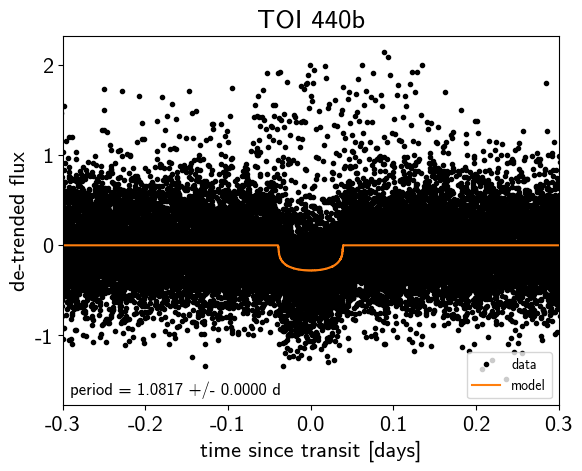

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

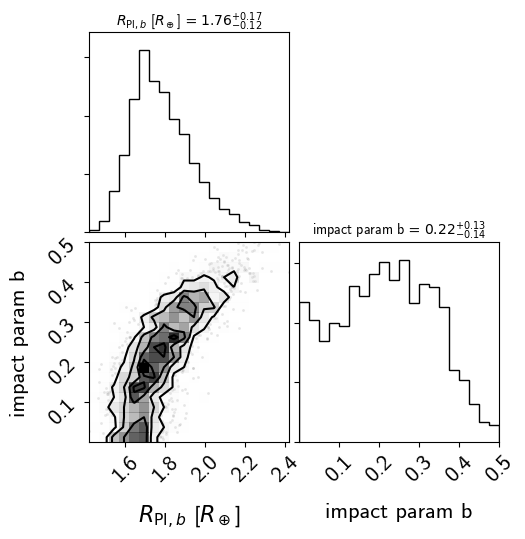

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

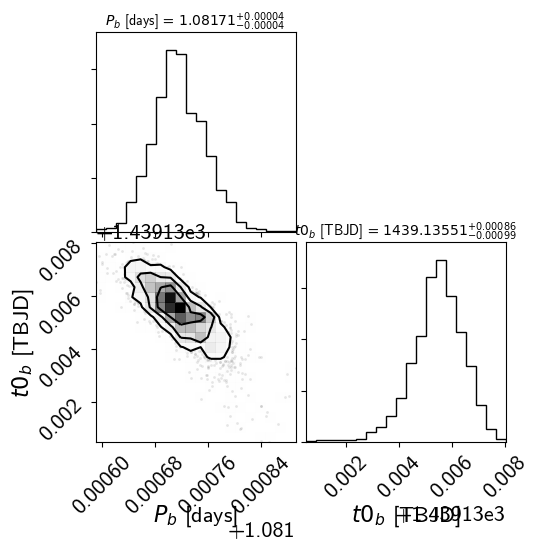

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

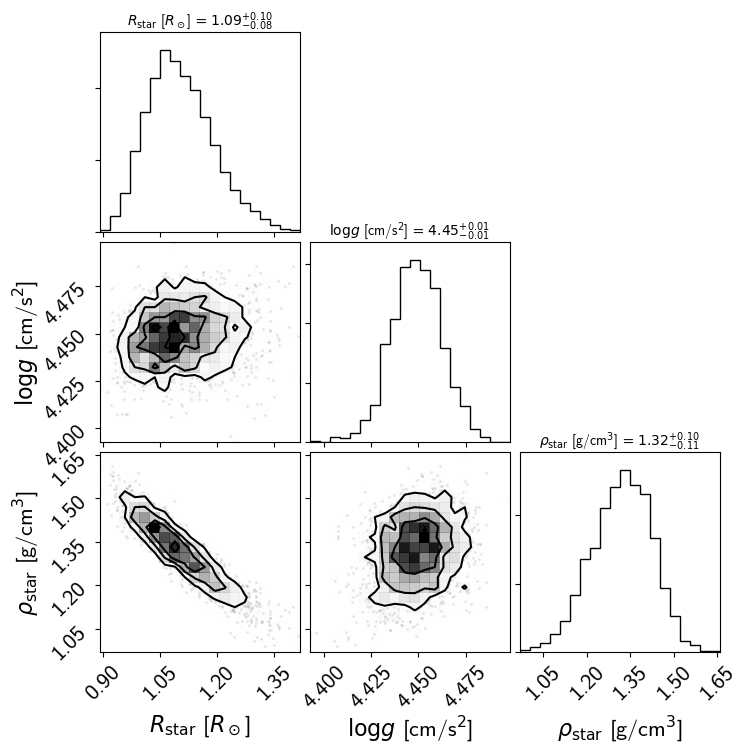

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3